<h1 align="center">
  <b>Code du projet : Analyse et prédiction du risque de crise cardiaque sur 8 763 individus</b>
</h1>

<p align="center">
  TRILLAUD Valorys
</p>
<p align="center">
  DUPAU Jasmine
</p>
<p align="center">
  Master 2 Econométrie et Statistiques Appliquées
</p>
<p align="center">
  Encadrées par Monsieur ROUL Benjamin
</p>

# Importation des packages

In [ ]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 547.8 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 40.6 MB/s eta 0:00:00

In [7]:
import pandas as pd
import os
import numpy as np
import plotly.express as px  # dataviz
import matplotlib.pyplot as plt # dataviz
import scipy.stats as stats
import statsmodels.api
import seaborn as sns

# Standardisation
from sklearn.preprocessing import StandardScaler

# Winsorization
from scipy.stats.mstats import winsorize

# Splitter le dataset
from sklearn.model_selection import train_test_split

# Modélisation = Classification
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Métriques
from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix , accuracy_score, recall_score, f1_score, roc_auc_score, precision_score



# Evaluation
from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV

#Interpretability
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from alibi.explainers import ALE, plot_ale

# Echantillonnage
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#Pour la fonction Grubbs et ESD = valeurs atypiques
import scipy.stats as stats

#Pour le test de khi2
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

# Fonctions

In [ ]:
# Importance des variables d'un SVM y compris la régression logistique
def svm_f_importances(coef_svm , names):
    '''
    Cette fonction permet de visualiser l'importance de chaque variable pour le modèle SVM
    Vous devez passer 2 arguments :

    - coef_svm : Les coefficients du modèle disponible après votre .fit()
      On le récupère avec la commande suite  svc_fit.coef_[0]

    - names : est le nom des features que vous avez utilisées.
      ATTENTION les passer dans le même ordre que pour l'entrainement du modèle

    '''
    imp = coef_svm
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title("Importance des variables")
    plt.show()

In [ ]:
#Indicateurs de performance des modèles - inspirée d'anciens étudiants du master
def indicateur(model, X, y, ech):
    # Prédiction du modèle
    valid_pred = model.predict(X).round()

    # Calcul des métriques
    conf_matrix = confusion_matrix(y, valid_pred)
    accuracy = accuracy_score(y, valid_pred)
    error_rate = 1 - accuracy
    recall = recall_score(y, valid_pred)
    precision = precision_score(y, valid_pred)
    f1 = f1_score(y, valid_pred)

    # Affichage des résultats
    print(f"\033[1mIndicateurs de l'échantillon {ech} :\033[0m")
    print(f"Matrice de confusion :\n{conf_matrix}")
    print(f"Qualité du modèle (Accuracy) : {round(accuracy, 2)}")
    print(f"Taux d'erreur : {round(error_rate, 2)}")
    print(f"Recall : {round(recall, 2)}")
    print(f"Precision : {round(precision, 2)}")
    print(f"F1 Score  : {round(f1, 2)}")


# I. Structure du jeu de données

In [8]:
import requests
import io

In [10]:
# Lecture du fichier
url = "https://raw.githubusercontent.com/jas056/SVM/refs/heads/main/Projet/heart_attack_prediction_dataset.csv"
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')
df

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,MSV9918,60,Male,121,94/76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,QSV6764,28,Female,120,157/102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,XKA5925,47,Male,250,161/75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,EPE6801,36,Male,178,119/67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


Le dataframe est composé de 8 763 observations et de 26 variables.

## Renommer les colonnes

In [ ]:
print(df.columns)

Index(['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Heart Attack Risk'],
      dtype='object')


Nous pouvons voir qu'il y a des espaces dans les noms de colonnes. Pour éviter tout problème lors de la modélisation, nous allons mettre un "_" à chaque espace.

In [ ]:
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
df

,Patient_ID,Age,Sex,Cholesterol,Blood_Pressure,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,...,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Country,Continent,Hemisphere,Heart_Attack_Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,MSV9918,60,Male,121,94/76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,QSV6764,28,Female,120,157/102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,XKA5925,47,Male,250,161/75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,EPE6801,36,Male,178,119/67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


Nous voyons que la colonne **Patient_ID** correspondant à l'identifiant des patients n'apporte pas d'informations pertinentes pour la modélisation. Nous allons donc la supprimer.

In [ ]:
df = df.drop(columns=['Patient_ID'])

In [ ]:
df

,Age,Sex,Cholesterol,Blood_Pressure,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,...,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Country,Continent,Hemisphere,Heart_Attack_Risk
0,67,Male,208,158/88,72,0,0,1,0,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165/93,98,1,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174/99,72,1,0,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163/100,73,1,1,1,0,1,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91/88,93,1,1,1,1,0,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94/76,61,1,1,1,0,1,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157/102,73,1,0,0,1,0,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161/75,105,0,1,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119/67,60,1,0,1,0,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


# Exploration du jeu de données

## Premier nettoyage des données


### 1) Valeurs des variables

In [ ]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'Age': [67 21 84 66 54 90 20 43 73 71 77 60 88 69 38 50 45 36 48 40 79 63 27 25
 86 42 52 29 30 47 44 33 51 70 85 31 56 24 74 72 55 26 53 46 57 22 35 39
 80 65 83 82 28 19 75 18 34 37 89 32 49 23 59 62 64 61 76 41 87 81 58 78
 68]
Unique values in column 'Sex': ['Male' 'Female']
Unique values in column 'Cholesterol': [208 389 324 383 318 297 358 220 145 248 373 374 228 259 122 379 166 303
 340 294 359 202 133 159 271 273 328 154 135 197 321 375 360 263 201 347
 129 229 251 121 190 185 279 336 192 180 203 368 222 243 218 120 285 377
 369 311 139 266 153 339 329 333 398 124 183 163 362 390 200 396 255 209
 247 250 227 246 223 330 195 194 178 155 240 237 216 276 224 326 198 301
 314 304 334 213 254 230 316 277 388 206 384 205 261 308 338 382 291 168
 171 378 253 245 226 281 123 173 231 234 268 306 186 293 161 380 239 149
 320 219 335 265 126 307 270 225 193 148 296 136 364 353 252 232 387 299
 357 214 370 345 351 344 152 150 131 272 302 337 170 356 274 188 125 138


Nous observons que la variable **Blood_Pressure** a des valeurs de la forme "x/y" où x = pression systolique et y = pression diastolique. Par conséquent, nous allons séparer les valeurs en créant 2 colonnes : "Pression_systolique" et "Pression_diastolique"

### 2) Manipulations sur les colonnes

In [ ]:
# Découper la colonne de "blood_pressure"
split_cols = df['Blood_Pressure'].str.split('/', expand=True)
split_cols.columns = ['Pression_systolique', 'Pression_diastolique']

# Convertir en numérique
split_cols['Pression_systolique'] = pd.to_numeric(split_cols['Pression_systolique'])
split_cols['Pression_diastolique'] = pd.to_numeric(split_cols['Pression_diastolique'])

# Insérer les colonnes à côté de celle de la tension artérielle
bp_index = df.columns.get_loc('Blood_Pressure') # index de la colonne
for i, col in enumerate(split_cols.columns):
    df.insert(bp_index + 1 + i, col, split_cols[col])
df

,Age,Sex,Cholesterol,Blood_Pressure,Pression_systolique,Pression_diastolique,Heart_Rate,Diabetes,Family_History,Smoking,...,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Country,Continent,Hemisphere,Heart_Attack_Risk
0,67,Male,208,158/88,158,88,72,0,0,1,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165/93,165,93,98,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174/99,174,99,72,1,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163/100,163,100,73,1,1,1,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91/88,91,88,93,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94/76,94,76,61,1,1,1,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157/102,157,102,73,1,0,0,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161/75,161,75,105,0,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119/67,119,67,60,1,0,1,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


In [ ]:
df = df.drop(columns=['Blood_Pressure'])

In [ ]:
df

,Age,Sex,Cholesterol,Pression_systolique,Pression_diastolique,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,...,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Country,Continent,Hemisphere,Heart_Attack_Risk
0,67,Male,208,158,88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165,93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174,99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163,100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91,88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94,76,61,1,1,1,0,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157,102,73,1,0,0,1,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161,75,105,0,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119,67,60,1,0,1,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


Nous pouvons créer la colonne **tension_artérielle** qui est le résultat du rapport des 2 colonnes créées.

In [ ]:
df['tension_artérielle'] = df['Pression_systolique'] / df['Pression_diastolique']

# position the columnsnext to 'Systolic' and 'Diastolic'
tension_arterielle_index = df.columns.get_loc('tension_artérielle')
df.insert(bp_index + 2, 'tension_artérielle', df.pop('tension_artérielle'))

# Arrondir à 2 chiffres après la virgule
df['tension_artérielle'] = df['tension_artérielle'].round(2)

In [ ]:
df

,Age,Sex,Cholesterol,Pression_systolique,Pression_diastolique,tension_artérielle,Heart_Rate,Diabetes,Family_History,Smoking,...,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Country,Continent,Hemisphere,Heart_Attack_Risk
0,67,Male,208,158,88,1.80,72,0,0,1,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,165,93,1.77,98,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,174,99,1.76,72,1,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,163,100,1.63,73,1,1,1,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,91,88,1.03,93,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,94,76,1.24,61,1,1,1,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,157,102,1.54,73,1,0,0,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,161,75,2.15,105,0,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,119,67,1.78,60,1,0,1,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


Maintenant que nous avons calculé la tension artérielle, nous allons suppimer les colonnes **Pression_systolique** et **Pression diastolique** afin de ne pas avoir de multicolinéarité puisque la tension provient de ces 2 caractéristiques.

In [ ]:
df = df.drop(columns=['Pression_systolique', 'Pression_diastolique'])

In [ ]:
df

,Age,Sex,Cholesterol,tension_artérielle,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,...,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Country,Continent,Hemisphere,Heart_Attack_Risk
0,67,Male,208,1.80,72,0,0,1,0,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,21,Male,389,1.77,98,1,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,21,Female,324,1.76,72,1,0,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,84,Male,383,1.63,73,1,1,1,0,1,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,66,Male,318,1.03,93,1,1,1,1,0,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,1.24,61,1,1,1,0,1,...,10.806373,235420,19.655895,67,7,7,Thailand,Asia,Northern Hemisphere,0
8759,28,Female,120,1.54,73,1,0,0,1,0,...,3.833038,217881,23.993866,617,4,9,Canada,North America,Northern Hemisphere,0
8760,47,Male,250,2.15,105,0,1,1,1,1,...,2.375214,36998,35.406146,527,4,4,Brazil,South America,Southern Hemisphere,1
8761,36,Male,178,1.78,60,1,0,1,0,0,...,0.029104,209943,27.294020,114,2,8,Brazil,South America,Southern Hemisphere,0


### 3) Typage des données

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   object 
 2   Cholesterol                      8763 non-null   int64  
 3   tension_artérielle               8763 non-null   float64
 4   Heart_Rate                       8763 non-null   int64  
 5   Diabetes                         8763 non-null   int64  
 6   Family_History                   8763 non-null   int64  
 7   Smoking                          8763 non-null   int64  
 8   Obesity                          8763 non-null   int64  
 9   Alcohol_Consumption              8763 non-null   int64  
 10  Exercise_Hours_Per_Week          8763 non-null   float64
 11  Diet                             8763 non-null   object 
 12  Previous_Heart_Probl

Nous observons que 5 variables ne sont pas bien formatées (car type = object). Il s'agit de variables qualitatives. Par conséquent, il faudra les typer en catégorielles.

In [ ]:
# Conversion en format catégoriel
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Age                              8763 non-null   int64   
 1   Sex                              8763 non-null   category
 2   Cholesterol                      8763 non-null   int64   
 3   tension_artérielle               8763 non-null   float64 
 4   Heart_Rate                       8763 non-null   int64   
 5   Diabetes                         8763 non-null   int64   
 6   Family_History                   8763 non-null   int64   
 7   Smoking                          8763 non-null   int64   
 8   Obesity                          8763 non-null   int64   
 9   Alcohol_Consumption              8763 non-null   int64   
 10  Exercise_Hours_Per_Week          8763 non-null   float64 
 11  Diet                             8763 non-null   category
 12  Previo

Les données sont à présent bien formatées. De plus, il n'y a pas de valeurs manquantes.

# II. Analyse exploratoire

L'analyse exploratoire est nécessaire avant la réalisation de la modélisation. En effet, elle permet de mieux comprendre le jeu de données à travers différentes représentations graphiques selon la nature des variables et de détecter in fine la présence ou non de valeurs aberrantes. Ces dernières seront à corriger car elles pourraient biaiser les résultats de la prédiction du risque cardiaque.

Avant de réaliser la visualisation de nos variables, nous trouvons intéressant de transformer nos variables booléennes en "oui-non" afin d'avoir une meilleure lecture des graphiques.

In [ ]:
# Tranformation des variables booléennes
for column in df.columns:
    if set(df[column].unique()) == {0, 1}:
        df[column] = df[column].replace({0: 'Non', 1: 'Oui'})

df

# vérif
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")


Unique values in column 'Age': [67 21 84 66 54 90 20 43 73 71 77 60 88 69 38 50 45 36 48 40 79 63 27 25
 86 42 52 29 30 47 44 33 51 70 85 31 56 24 74 72 55 26 53 46 57 22 35 39
 80 65 83 82 28 19 75 18 34 37 89 32 49 23 59 62 64 61 76 41 87 81 58 78
 68]
Unique values in column 'Sex': ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Unique values in column 'Cholesterol': [208 389 324 383 318 297 358 220 145 248 373 374 228 259 122 379 166 303
 340 294 359 202 133 159 271 273 328 154 135 197 321 375 360 263 201 347
 129 229 251 121 190 185 279 336 192 180 203 368 222 243 218 120 285 377
 369 311 139 266 153 339 329 333 398 124 183 163 362 390 200 396 255 209
 247 250 227 246 223 330 195 194 178 155 240 237 216 276 224 326 198 301
 314 304 334 213 254 230 316 277 388 206 384 205 261 308 338 382 291 168
 171 378 253 245 226 281 123 173 231 234 268 306 186 293 161 380 239 149
 320 219 335 265 126 307 270 225 193 148 296 136 364 353 252 232 387 299
 357 214 370 345 351 344 152 

Cela a fonctionné.

## A. Analyse univariée

### Variable d'intérêt

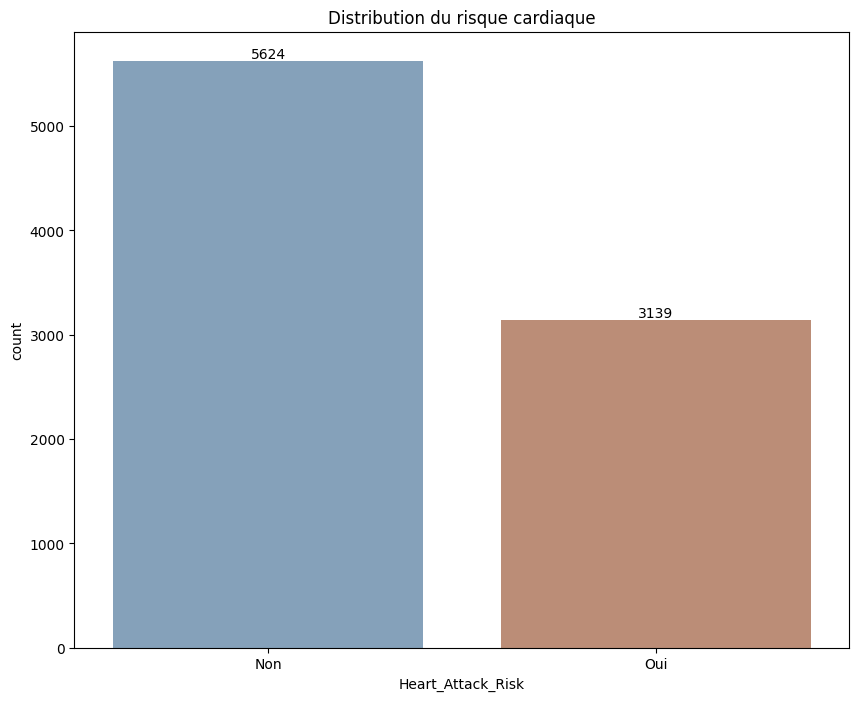

In [ ]:
plt.figure(figsize = (10,8))
ax = sns.countplot(x='Heart_Attack_Risk', data=df, palette = "twilight_shifted")
ax.set_title("Distribution du risque cardiaque")
for i in ax.containers:
    ax.bar_label(i,)

#px.bar(df["Heart_Attack_Risk"].value_counts(), text_auto=True, color_discrete_sequence=["blue"], width=600, height=500)

Heart_Attack_Risk
Non    64.178934
Oui    35.821066
Name: proportion, dtype: float64


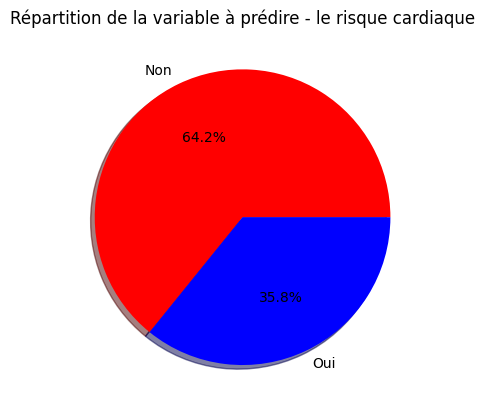

In [ ]:
print(df["Heart_Attack_Risk"].value_counts(normalize=True) * 100)

#Répartition de Comedy et Drama
tab_freq=df.Heart_Attack_Risk.value_counts(normalize=True)


plt.pie(
    tab_freq,
    labels = tab_freq.index,
    colors=['red', 'blue'],
    autopct='%1.1f%%',
    shadow=True,)

plt.title("Répartition de la variable à prédire - le risque cardiaque")
plt.show()

Le diagramme en bâtons et le calcul des proportions de chacune des modalités de la variable cible nous montrent un déséquilibre dans les données. Il faudra alors corriger ce dernier avant de réaliser la modélisation.

### Prédicteurs quantitatifs

<Figure size 1500x1000 with 0 Axes>

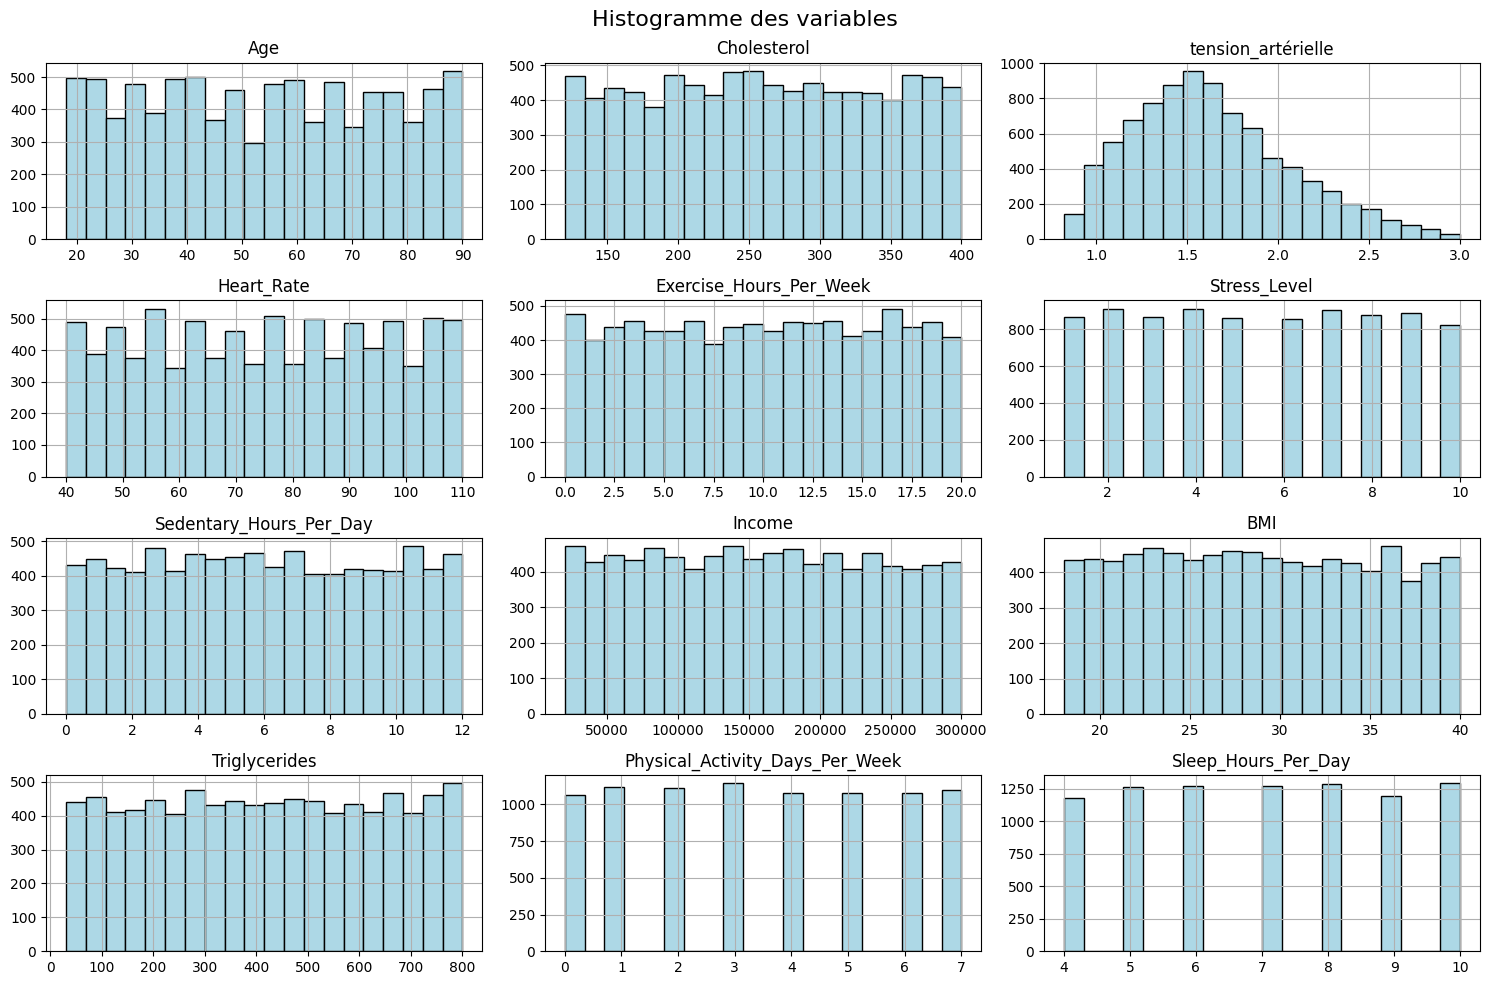

In [ ]:
#Exclure toutes les variables qualitatives
features_quanti = df.select_dtypes(exclude=["object", "category"])

plt.figure(figsize=(15, 10))

features_quanti.hist(bins=20, edgecolor='black', figsize=(15, 10), color = "lightblue")

plt.suptitle('Histogramme des variables', fontsize=16)
plt.tight_layout()
plt.show()

### Prédicteurs qualitatifs

In [ ]:
df.columns

Index(['Age', 'Sex', 'Cholesterol', 'tension_artérielle', 'Heart_Rate',
       'Diabetes', 'Family_History', 'Smoking', 'Obesity',
       'Alcohol_Consumption', 'Exercise_Hours_Per_Week', 'Diet',
       'Previous_Heart_Problems', 'Medication_Use', 'Stress_Level',
       'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides',
       'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day', 'Country',
       'Continent', 'Hemisphere', 'Heart_Attack_Risk'],
      dtype='object')

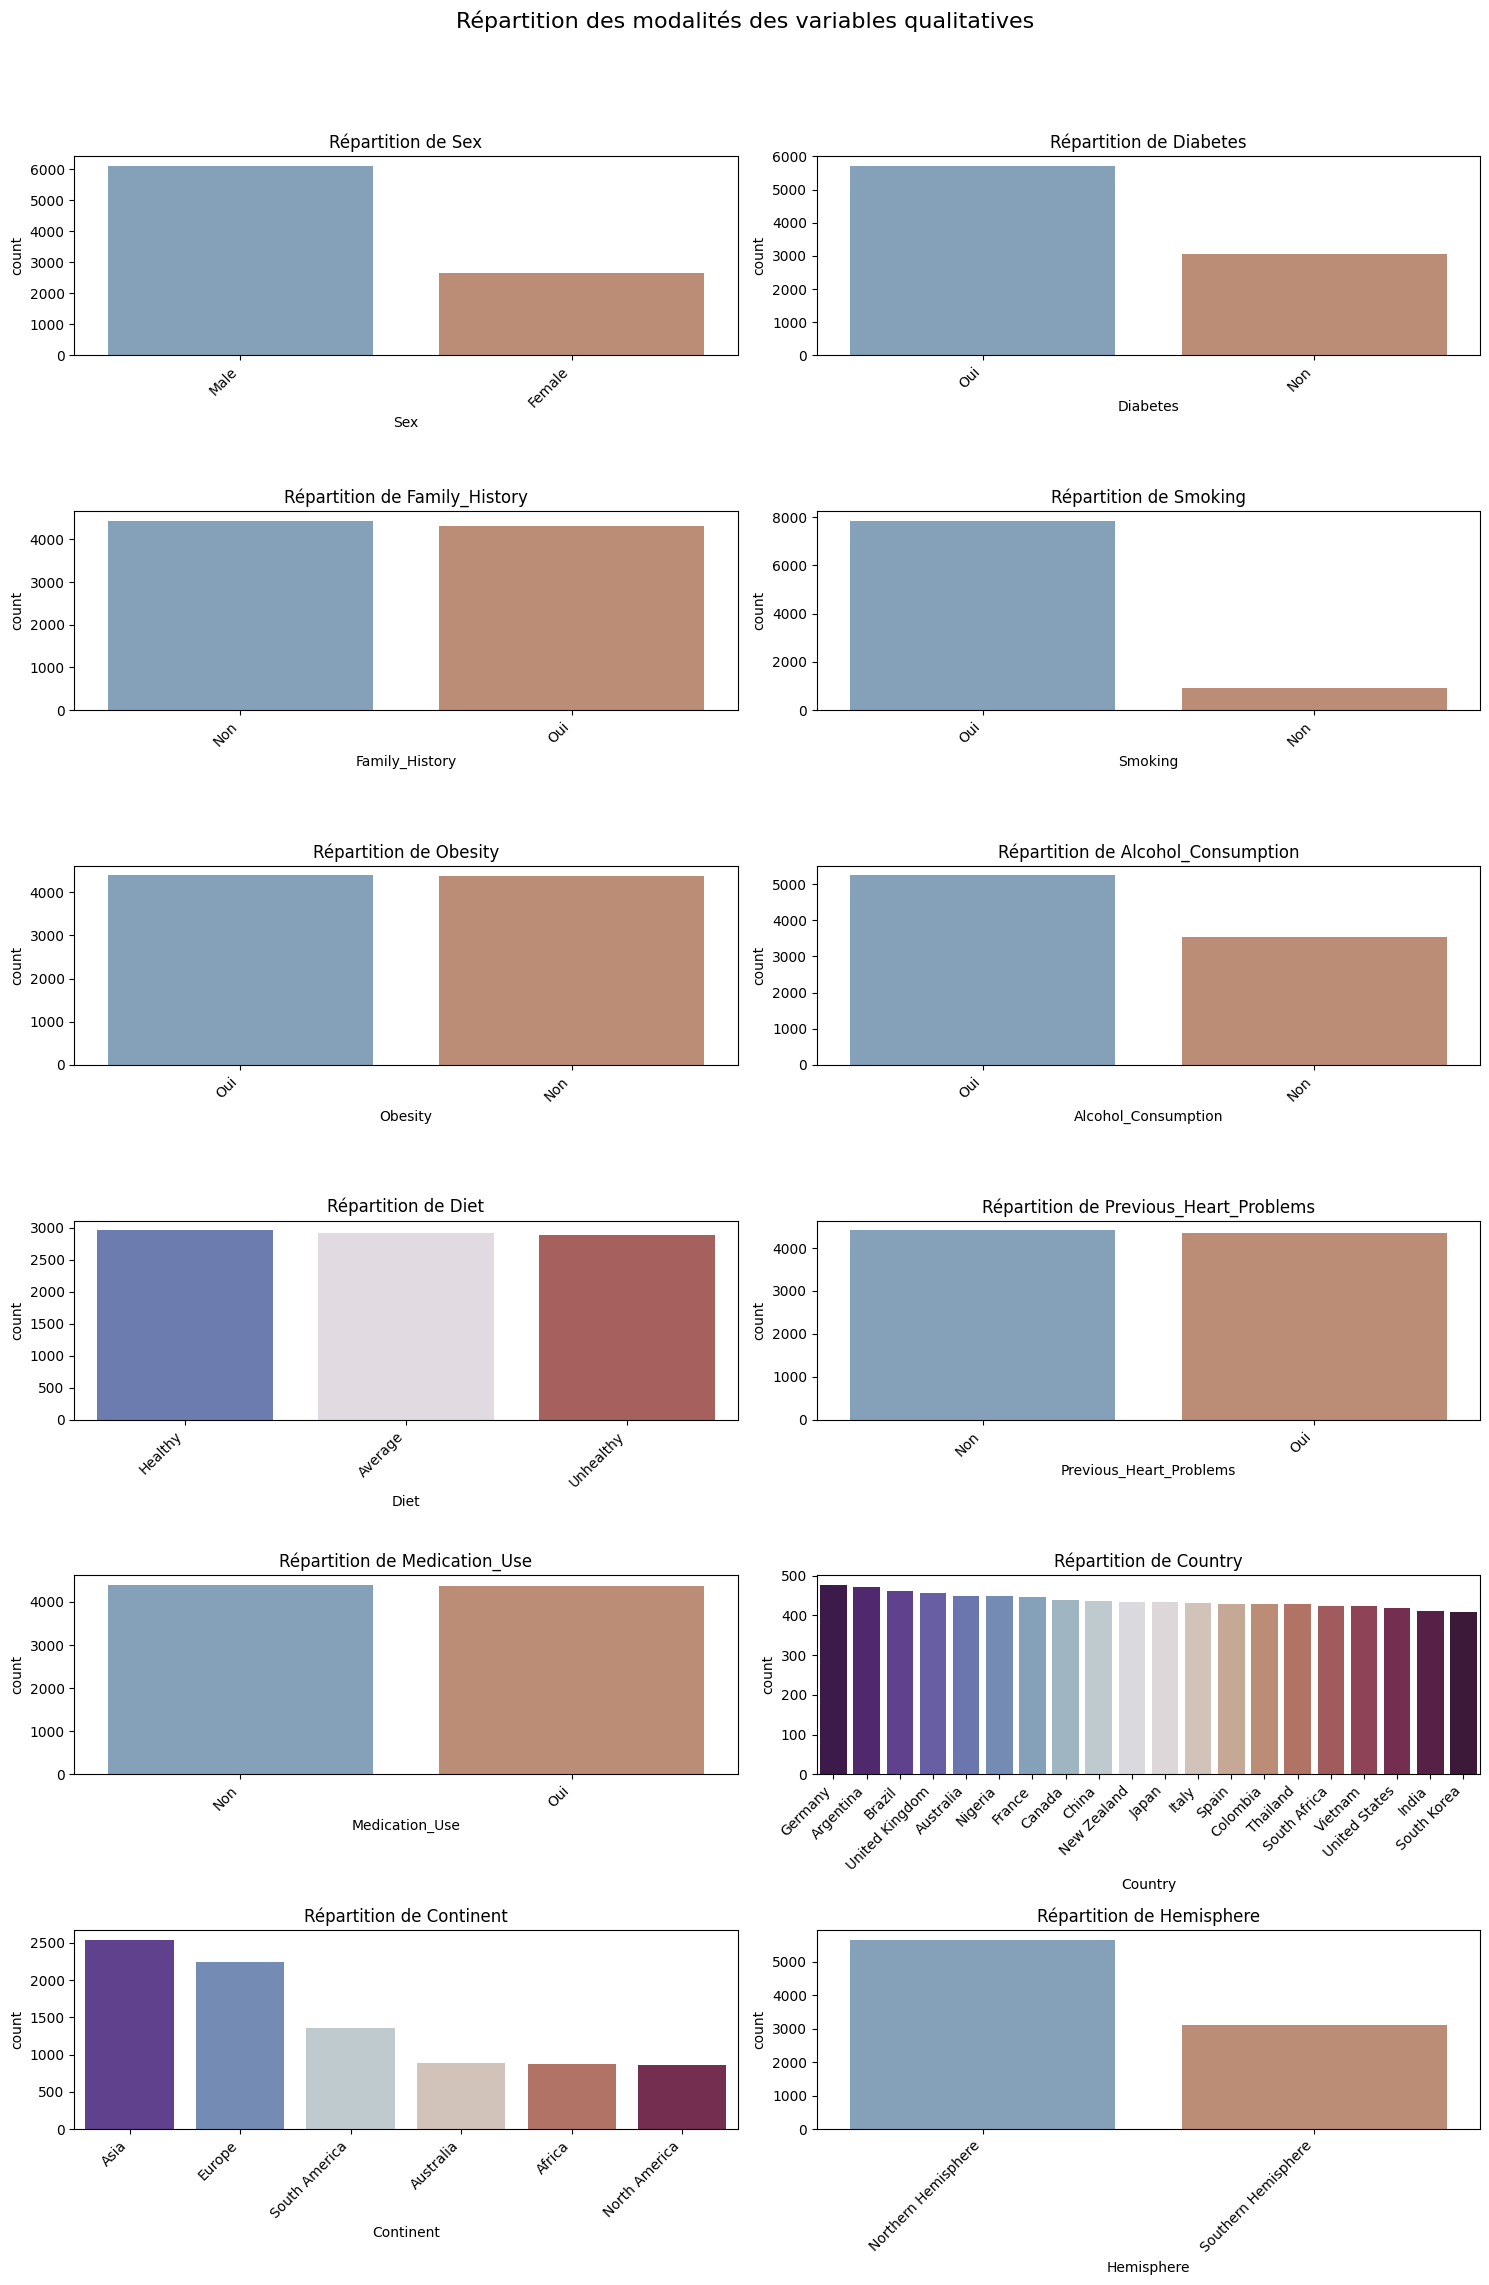

In [ ]:
# Sélectionner uniquement les variables qualitatives
features_quali = df.select_dtypes(exclude=["int64", "float64"]).drop(columns=["Heart_Attack_Risk"])

# Nombre de variables qualitatives
num_vars = len(features_quali.columns)

# Définir le nombre de lignes et de colonnes dynamiquement
ncols = 2  # On veut 2 colonnes
nrows = (num_vars // ncols) + (num_vars % ncols > 0)  # Calcul automatique du nombre de lignes

# Créer la figure avec sous-graphiques
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
fig.suptitle('Répartition des modalités des variables qualitatives', fontsize=16)

# Aplatir `axes` pour une indexation simple
axes = axes.flatten()

# Boucle sur chaque variable qualitative
for i, col in enumerate(features_quali.columns):
    order = features_quali[col].value_counts().index  # Trier par fréquence
    sns.countplot(ax=axes[i], x=features_quali[col], palette="twilight_shifted", order=order)
    axes[i].set_title(f"Répartition de {col}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

# Supprimer les axes vides si le nombre de variables < total des sous-graphiques
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuste l'espacement
plt.show()


Ces différents diagramme en bâtons permettent d'observer les principales caractéristiques des patients de notre échantillon. En effet, le jeu de données est majoritairement constitué d'hommes, venant de pays asiatiques et européens de l'hémisphère nord. De plus, ce sont des fumeurs diabétiques qui consomment de l'alcool. Pour les autres caractéristiques, nous voyons que c'est équilibré.

## B. Analyse bivariée

### 1) Variable cible et les prédicteurs qualitatifs principaux

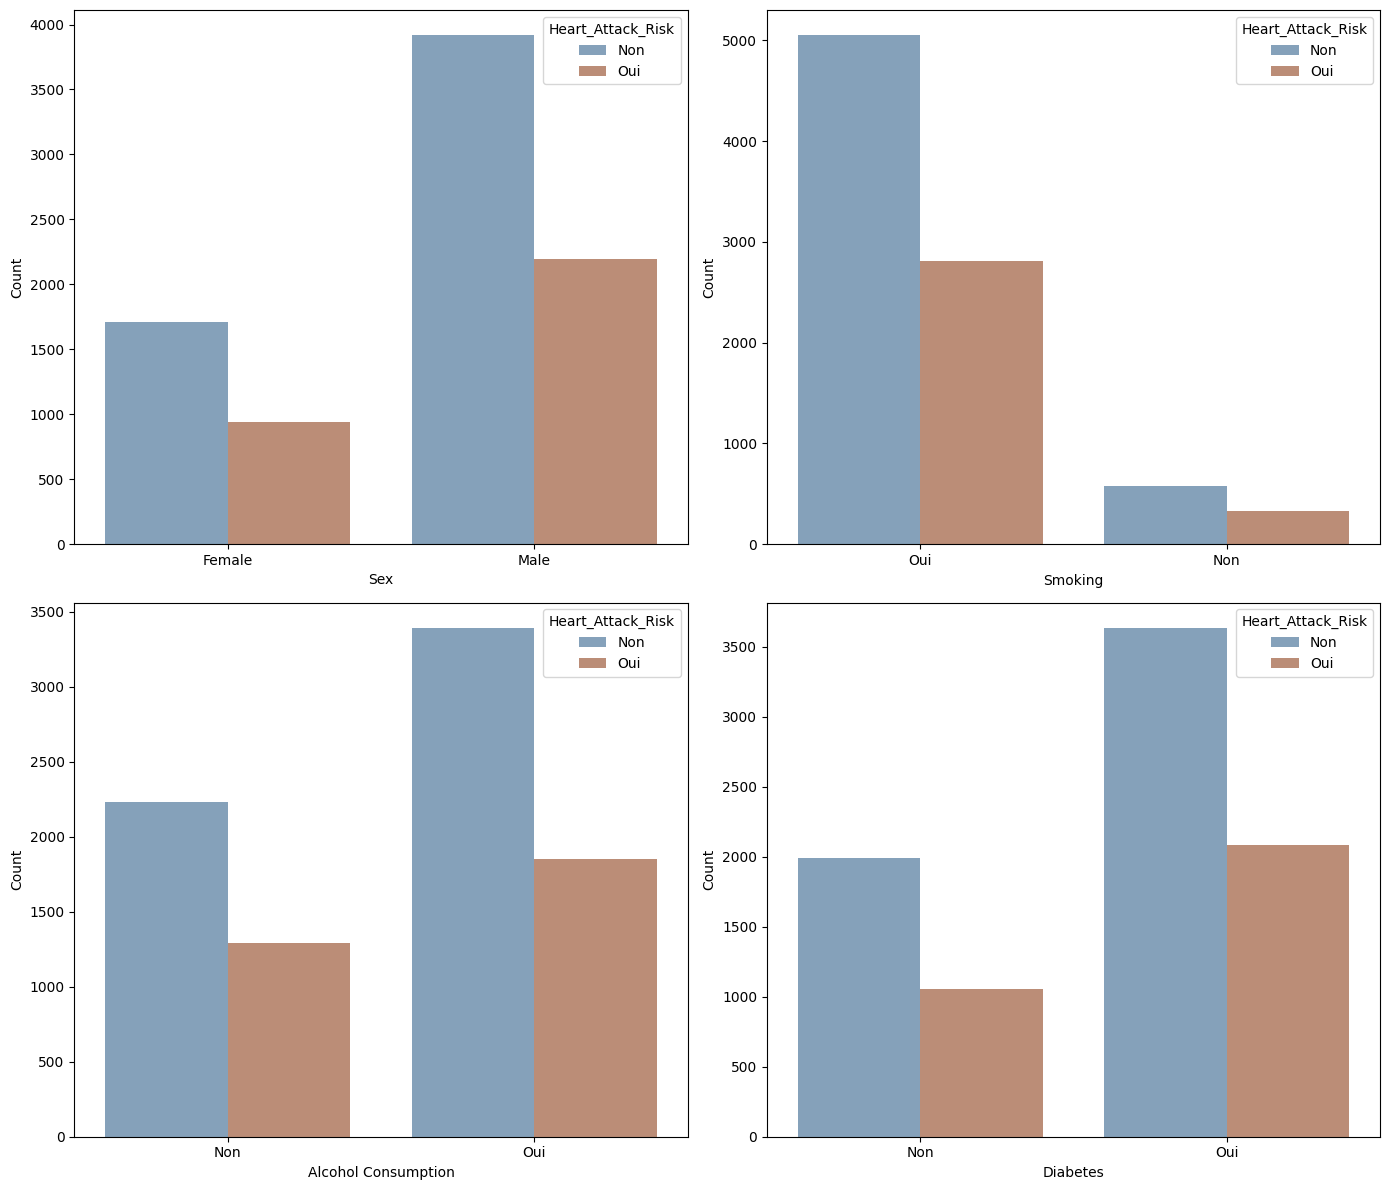

In [ ]:
# Créer une figure avec 2 lignes et 2 colonnes
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Graphique pour "Sex"
sns.countplot(data=df, x='Sex', hue='Heart_Attack_Risk', palette='twilight_shifted', ax=axs[0, 0])
axs[0, 0].set_xlabel('Sex')
axs[0, 0].set_ylabel('Count')

# Graphique pour "Smoking"
sns.countplot(data=df, x='Smoking', hue='Heart_Attack_Risk', palette='twilight_shifted', ax=axs[0, 1])
axs[0, 1].set_xlabel('Smoking')
axs[0, 1].set_ylabel('Count')

# Graphique pour "Alcohol Consumption"
sns.countplot(data=df, x='Alcohol_Consumption', hue='Heart_Attack_Risk', palette='twilight_shifted', ax=axs[1, 0])
axs[1, 0].set_xlabel('Alcohol Consumption')
axs[1, 0].set_ylabel('Count')

# Graphique pour "Diabetes"
sns.countplot(data=df, x='Diabetes', hue='Heart_Attack_Risk', palette='twilight_shifted', ax=axs[1, 1])
axs[1, 1].set_xlabel('Diabetes')
axs[1, 1].set_ylabel('Count')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()

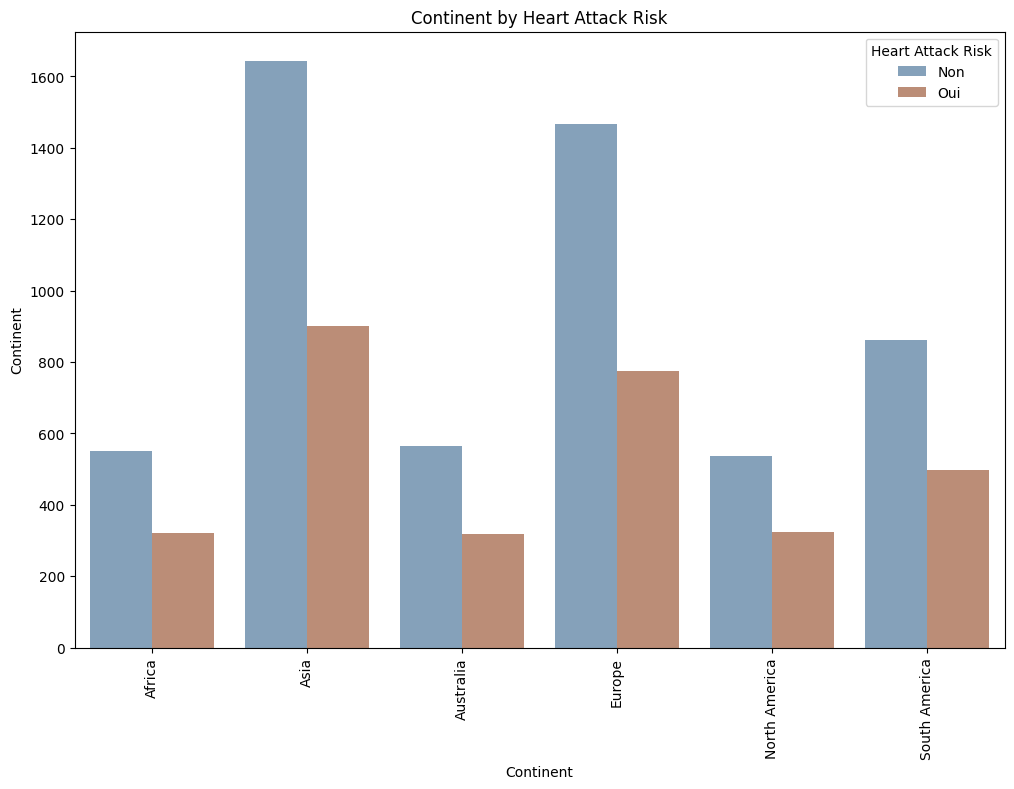

In [ ]:
# Plotting Continent vs Heart Attack Risk
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Continent', hue='Heart_Attack_Risk', palette='twilight_shifted')

# Labels and title
plt.title('Continent by Heart Attack Risk')
plt.xlabel('Continent')
plt.ylabel('Continent')
plt.xticks(rotation=90)  # Rotate country labels to fit them
plt.legend(title='Heart Attack Risk', labels=['Non', 'Oui'])
plt.show()

Au regard de cet histogramme, les patients proviennent principalement de l'Asie et de l'Europe.

### 2) Etude des corrélations

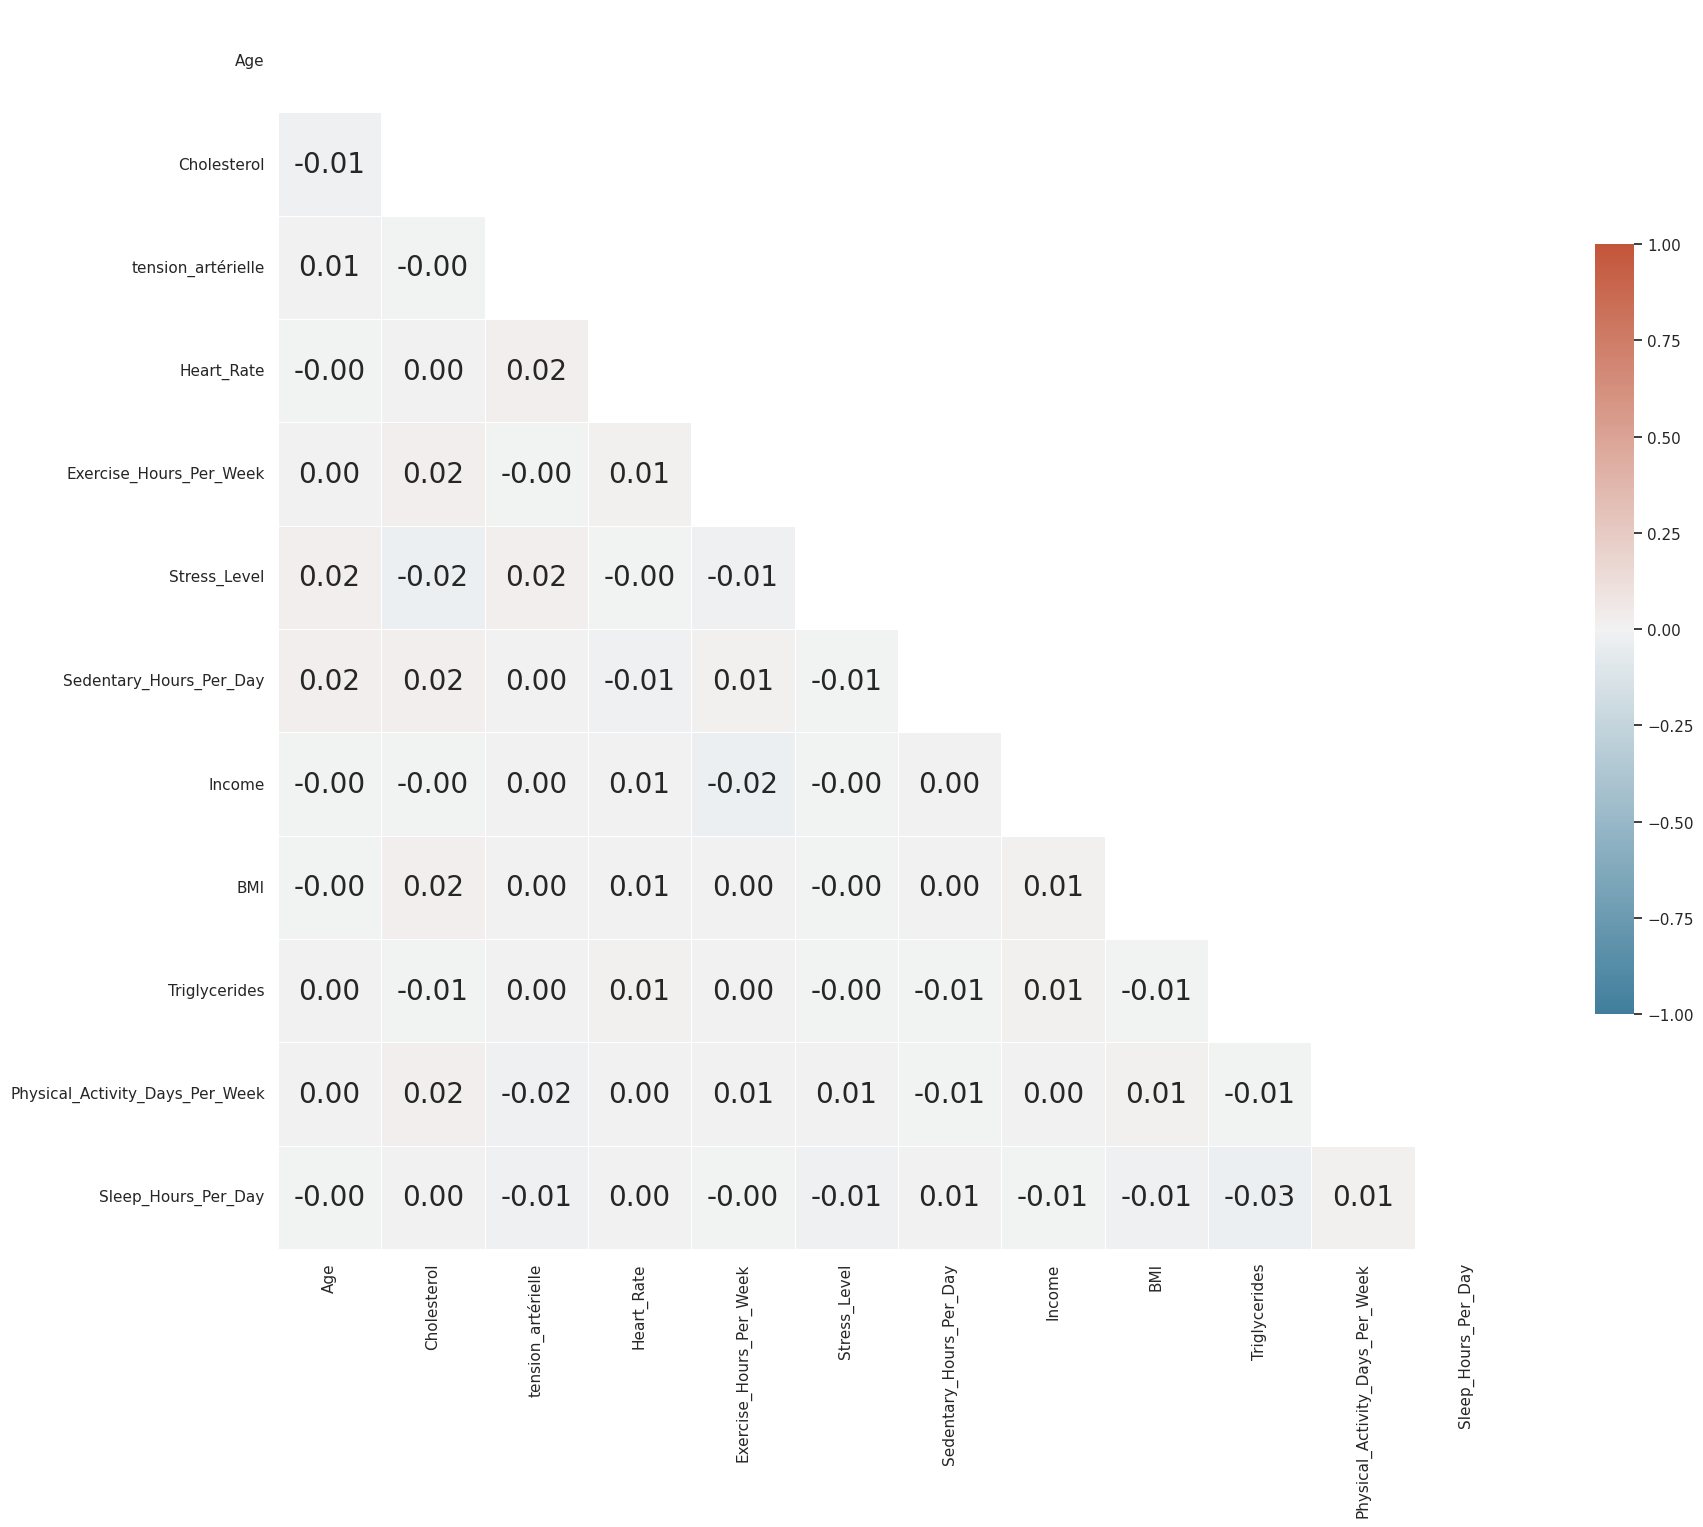

In [ ]:
sns.set(style="white")

# On calcule la matrice de corrélation
corr = features_quanti.corr(method='spearman')

# On génère un masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr, dtype=bool))

# On crée la figure matplotlib
fig, ax = plt.subplots(figsize=(20, 20))

# Une palette de couleurs
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# On dessine la heatmap avec le masque et un ratio d'aspect
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            annot_kws={"size": 20},
            fmt='.2f'
            )
plt.show()

Selon la matrice des corrélations, nous observons que les variables quantitatives ne sont pas liées entre elles.

### 3) Liens entre les variables qualitatives = utilisation du test de Chi2

In [ ]:
features_quali = df.select_dtypes(exclude=["int64", "float64"])

# Création d'un tableau pour stocker les résultats (dépendant ou non)
dependency_table = pd.DataFrame(index=features_quali.columns, columns=features_quali.columns)

# Test du chi-deux pour chaque paire de variables
for col1 in features_quali.columns:
    for col2 in features_quali.columns:
        if col1 != col2:
            contingency_table = pd.crosstab(features_quali[col1], features_quali[col2])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            dependency_table.loc[col1, col2] = "Oui" if p < 0.05 else "Non"

# Affichage du tableau des résultats de dépendance
print("Tableau des résultats de dépendance entre les variables (seuil=0.05) :")
dependency_table

Tableau des résultats de dépendance entre les variables (seuil=0.05) :


,Sex,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,Diet,Previous_Heart_Problems,Medication_Use,Country,Continent,Hemisphere,Heart_Attack_Risk
Sex,NaN,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non
Diabetes,Non,NaN,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non
Family_History,Non,Non,NaN,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non
Smoking,Oui,Non,Non,NaN,Non,Non,Non,Non,Non,Non,Non,Non,Non
Obesity,Non,Non,Non,Non,NaN,Oui,Non,Non,Non,Non,Non,Non,Non
Alcohol_Consumption,Non,Non,Non,Non,Oui,NaN,Non,Non,Non,Non,Non,Non,Non
Diet,Non,Non,Non,Non,Non,Non,NaN,Non,Non,Non,Non,Non,Non
Previous_Heart_Problems,Non,Non,Non,Non,Non,Non,Non,NaN,Non,Non,Non,Non,Non
Medication_Use,Non,Non,Non,Non,Non,Non,Non,Non,NaN,Non,Non,Non,Non
Country,Non,Non,Non,Non,Non,Non,Non,Non,Non,NaN,Oui,Oui,Non


Les résultats du test montrent que la variable cible n'est pas non plus liée avec les prédicteurs qualitatifs. En revanche, nous voyons que les variables donnant des informations géographiques sont liées entre elles. Par conséquent, nous allons supprimer le pays et l'hémisphère car nous trouvons que le continent regroupe les informations nécessaires. De plus, la consommation d'alcool est liée à l'obsésité et le fait de fumer est lié au genre. Malgré ces liens, nous décidons de les conserver car elles sont pertinentes pour la prédiction du risque cardiaque.

In [ ]:
#supprimer country et hemisphere
df = df.drop(columns=['Country', 'Hemisphere'])
df

,Age,Sex,Cholesterol,tension_artérielle,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,...,Medication_Use,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Continent,Heart_Attack_Risk
0,67,Male,208,1.80,72,Non,Non,Oui,Non,Non,...,Non,9,6.615001,261404,31.251233,286,0,6,South America,Non
1,21,Male,389,1.77,98,Oui,Oui,Oui,Oui,Oui,...,Non,1,4.963459,285768,27.194973,235,1,7,North America,Non
2,21,Female,324,1.76,72,Oui,Non,Non,Non,Non,...,Oui,9,9.463426,235282,28.176571,587,4,4,Europe,Non
3,84,Male,383,1.63,73,Oui,Oui,Oui,Non,Oui,...,Non,9,7.648981,125640,36.464704,378,3,4,North America,Non
4,66,Male,318,1.03,93,Oui,Oui,Oui,Oui,Non,...,Non,6,1.514821,160555,21.809144,231,1,5,Asia,Non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,1.24,61,Oui,Oui,Oui,Non,Oui,...,Oui,8,10.806373,235420,19.655895,67,7,7,Asia,Non
8759,28,Female,120,1.54,73,Oui,Non,Non,Oui,Non,...,Non,8,3.833038,217881,23.993866,617,4,9,North America,Non
8760,47,Male,250,2.15,105,Non,Oui,Oui,Oui,Oui,...,Non,5,2.375214,36998,35.406146,527,4,4,South America,Oui
8761,36,Male,178,1.78,60,Oui,Non,Oui,Non,Non,...,Oui,5,0.029104,209943,27.294020,114,2,8,South America,Non


In [ ]:
df.shape

(8763, 23)

Le jeu de données est désormais constitué de 8 763 observations et 23 variables.

# III. Modélisation

## A. Préparation des données

### 1) Deuxième nettoyage des données

- Etude des outliers : boxplots des variables quantitatives standardisées

Nous allons procéder à une standardisation des données qui permet de mettre les données à la même échelle pour avoir une meilleure lisibilité des graphiques.

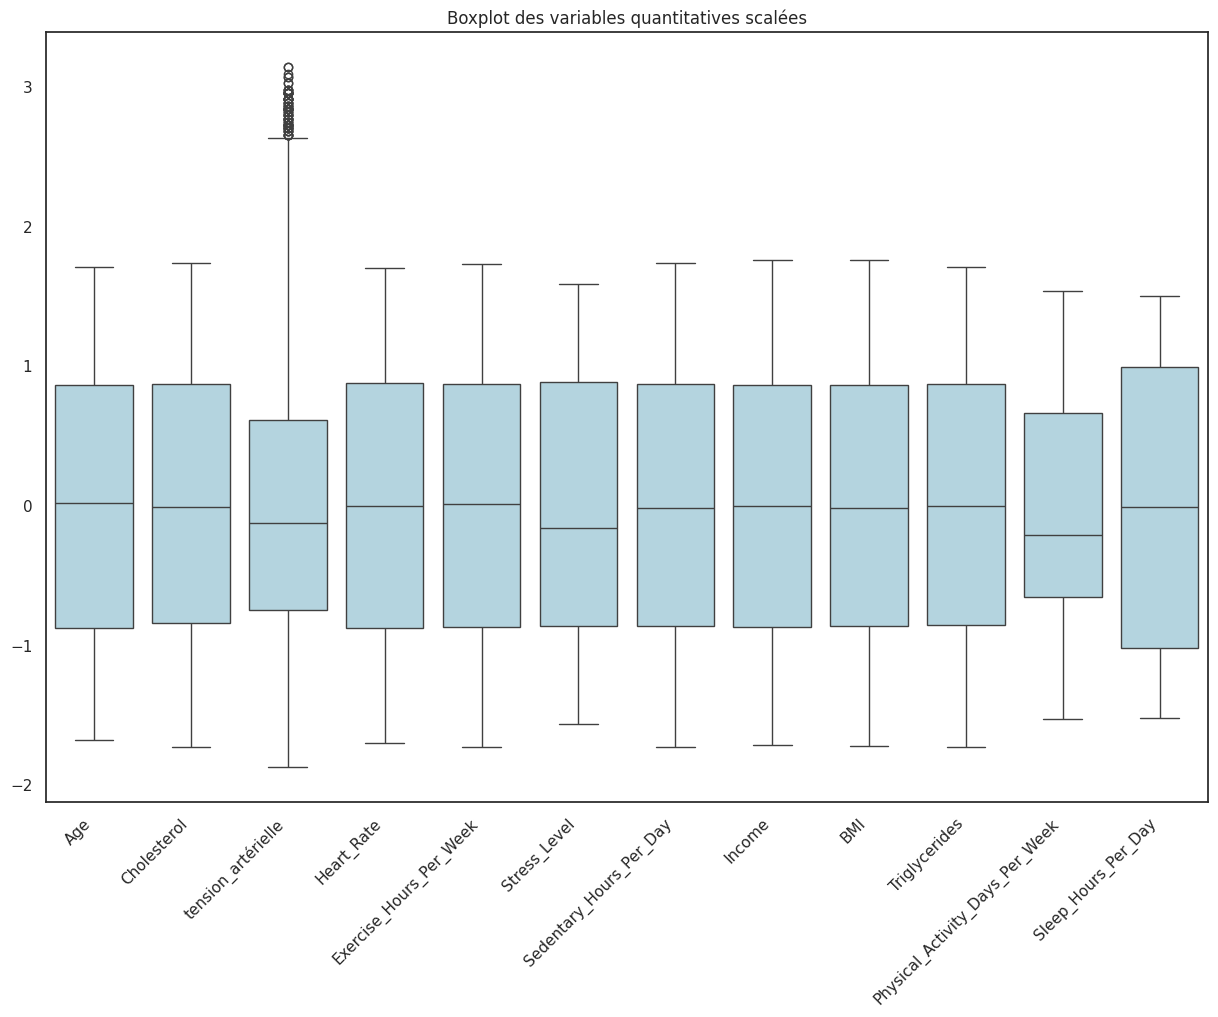

In [ ]:
# Appliquer la standardization (z-score)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(features_quanti), columns=features_quanti.columns)


# Créer un boxplot pour toutes les variables numériques
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_scaled, color='lightblue')
plt.title('Boxplot des variables quantitatives scalées')

plt.xticks(rotation=45, ha="right")
# Afficher le graphique
plt.show()

Les boîtes à moustaches permettent de visualiser ou non la présence de valeurs atypiques. Nous pouvons voir que la tension artérielle est la seule à présenter des points en dehors de sa boîte. Cependant, ils sont proches de sa distribution. <br>
Le prochain travail va donc consister à vérifier si ce sont effectivement des valeurs atypiques à l'aide du test ESD.

- Test ESD

In [ ]:
# #Test ESD repris de Firmin (étudiant d'une ancienne promo du master)

def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
    #print("Grubbs Statistics Value : {}".format(Gcal))
    return Gcal, max_ind

def calculate_critical_value(size, alpha):
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    #print("Grubbs Critical Value: {}".format(critical_value))
    return critical_value

#ESD test
def ESD_Test(input_series, alpha, max_outliers):
    input_series = np.array(input_series) #Transformation de la colonne en array

    #Initialisation des valeurs
    nb_outliers=0
    valeur_atypique_seuil="-"


    #Itération pour chaque valeur de la série
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)

        #Récupère les valeurs de la dernière itération où la valeur est considéré comme atypique
        if round(Gstat,4)>round(Gcritical,4) :
            nb_outliers+=1
            valeur_atypique_seuil=input_series[max_index]
            last_Gstat=Gstat
            last_Gcritical=Gcritical

        #Supprime la valeur de l'itération pour tester sur d'autres
        input_series = np.delete(input_series, max_index)

    #Print des résultats du test
    print("Nombre de valeurs atypiques : "+ str(nb_outliers))
    print("Valeur atypique seuil : {}".format(valeur_atypique_seuil))

    if nb_outliers>0 :
        print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(valeur_atypique_seuil, last_Gstat, last_Gcritical))

    if (max_outliers*0.8)<nb_outliers : #Marge de sécurité
        print('\033[1m' + "Veuillez augmenter le nombre d'outlier max par sécurité"+'\033[0m')

    return valeur_atypique_seuil

In [ ]:
# Appliquer le test ESD à chaque colonne de features_quanti
for column in features_quanti.columns:
    print(f"Test ESD pour la colonne : {column}")
    ESD_Test(features_quanti[column], alpha=0.05, max_outliers=1000)
    print('-----------------------------------------------')

Test ESD pour la colonne : Age
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
-----------------------------------------------
Test ESD pour la colonne : Cholesterol
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
-----------------------------------------------
Test ESD pour la colonne : tension_artérielle
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
-----------------------------------------------
Test ESD pour la colonne : Heart_Rate
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
-----------------------------------------------
Test ESD pour la colonne : Exercise_Hours_Per_Week
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
-----------------------------------------------
Test ESD pour la colonne : Stress_Level
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
-----------------------------------------------
Test ESD pour la colonne : Sedentary_Hours_Per_Day
Nombre de valeurs atypiques : 0
Valeur atypique seuil : -
----------

Le test n'a pas détecté de valeurs atypiques. Par conséquent, les points figurant sur le boxplot ne sont pas des valeurs atypiques. <br>
Il n'est donc pas nécessaire de winsoriser les données.

### 2) Encodage des variables qualitatives

In [ ]:
# Encoder les variables booléennes
for column in df.columns:
    if df[column].dtype == 'object' and df[column].isin(['Oui', 'Non']).all():
        df[column] = df[column].map({'Non': 0, 'Oui': 1})

# Vérifier
df

,Age,Sex,Cholesterol,tension_artérielle,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,...,Medication_Use,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Continent,Heart_Attack_Risk
0,67,Male,208,1.80,72,0,0,1,0,0,...,0,9,6.615001,261404,31.251233,286,0,6,South America,0
1,21,Male,389,1.77,98,1,1,1,1,1,...,0,1,4.963459,285768,27.194973,235,1,7,North America,0
2,21,Female,324,1.76,72,1,0,0,0,0,...,1,9,9.463426,235282,28.176571,587,4,4,Europe,0
3,84,Male,383,1.63,73,1,1,1,0,1,...,0,9,7.648981,125640,36.464704,378,3,4,North America,0
4,66,Male,318,1.03,93,1,1,1,1,0,...,0,6,1.514821,160555,21.809144,231,1,5,Asia,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,60,Male,121,1.24,61,1,1,1,0,1,...,1,8,10.806373,235420,19.655895,67,7,7,Asia,0
8759,28,Female,120,1.54,73,1,0,0,1,0,...,0,8,3.833038,217881,23.993866,617,4,9,North America,0
8760,47,Male,250,2.15,105,0,1,1,1,1,...,0,5,2.375214,36998,35.406146,527,4,4,South America,1
8761,36,Male,178,1.78,60,1,0,1,0,0,...,1,5,0.029104,209943,27.294020,114,2,8,South America,0


In [ ]:
# modalités des variables
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'Age': [67 21 84 66 54 90 20 43 73 71 77 60 88 69 38 50 45 36 48 40 79 63 27 25
 86 42 52 29 30 47 44 33 51 70 85 31 56 24 74 72 55 26 53 46 57 22 35 39
 80 65 83 82 28 19 75 18 34 37 89 32 49 23 59 62 64 61 76 41 87 81 58 78
 68]
Unique values in column 'Sex': ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Unique values in column 'Cholesterol': [208 389 324 383 318 297 358 220 145 248 373 374 228 259 122 379 166 303
 340 294 359 202 133 159 271 273 328 154 135 197 321 375 360 263 201 347
 129 229 251 121 190 185 279 336 192 180 203 368 222 243 218 120 285 377
 369 311 139 266 153 339 329 333 398 124 183 163 362 390 200 396 255 209
 247 250 227 246 223 330 195 194 178 155 240 237 216 276 224 326 198 301
 314 304 334 213 254 230 316 277 388 206 384 205 261 308 338 382 291 168
 171 378 253 245 226 281 123 173 231 234 268 306 186 293 161 380 239 149
 320 219 335 265 126 307 270 225 193 148 296 136 364 353 252 232 387 299
 357 214 370 345 351 344 152 

Il reste à encoder les variables **Sex**, **Diet** et **Continent**. Pour ce faire, nous allons faire appel à la fonction *LabelEncoder*.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Création de l'objet LabelEncoder
label_encoder_sex = LabelEncoder()
label_encoder_diet = LabelEncoder()
label_encoder_continent = LabelEncoder()

# Appliquer LabelEncoder aux variables individuellement
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])
df['Diet'] = label_encoder_diet.fit_transform(df['Diet'])
df['Continent'] = label_encoder_continent.fit_transform(df['Continent'])

# Afficher les correspondances pour chaque variable
print(f"Colonne : Sex")
print(dict(zip(label_encoder_sex.classes_, label_encoder_sex.transform(label_encoder_sex.classes_))))

print(f"\nColonne : Diet")
print(dict(zip(label_encoder_diet.classes_, label_encoder_diet.transform(label_encoder_diet.classes_))))

print(f"\nColonne : Continent")
print(dict(zip(label_encoder_continent.classes_, label_encoder_continent.transform(label_encoder_continent.classes_))))

# Afficher les premières lignes du DataFrame après encodage
df.head(5)

Colonne : Sex
{'Female': 0, 'Male': 1}

Colonne : Diet
{'Average': 0, 'Healthy': 1, 'Unhealthy': 2}

Colonne : Continent
{'Africa': 0, 'Asia': 1, 'Australia': 2, 'Europe': 3, 'North America': 4, 'South America': 5}


,Age,Sex,Cholesterol,tension_artérielle,Heart_Rate,Diabetes,Family_History,Smoking,Obesity,Alcohol_Consumption,...,Medication_Use,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day,Continent,Heart_Attack_Risk
0,67,1,208,1.80,72,0,0,1,0,0,...,0,9,6.615001,261404,31.251233,286,0,6,5,0
1,21,1,389,1.77,98,1,1,1,1,1,...,0,1,4.963459,285768,27.194973,235,1,7,4,0
2,21,0,324,1.76,72,1,0,0,0,0,...,1,9,9.463426,235282,28.176571,587,4,4,3,0
3,84,1,383,1.63,73,1,1,1,0,1,...,0,9,7.648981,125640,36.464704,378,3,4,4,0
4,66,1,318,1.03,93,1,1,1,1,0,...,0,6,1.514821,160555,21.809144,231,1,5,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8763 non-null   int64  
 1   Sex                              8763 non-null   int64  
 2   Cholesterol                      8763 non-null   int64  
 3   tension_artérielle               8763 non-null   float64
 4   Heart_Rate                       8763 non-null   int64  
 5   Diabetes                         8763 non-null   int64  
 6   Family_History                   8763 non-null   int64  
 7   Smoking                          8763 non-null   int64  
 8   Obesity                          8763 non-null   int64  
 9   Alcohol_Consumption              8763 non-null   int64  
 10  Exercise_Hours_Per_Week          8763 non-null   float64
 11  Diet                             8763 non-null   int64  
 12  Previous_Heart_Probl

### 3) Spliter le jeu de données

In [ ]:
X = df.iloc[:, :-1]
y = df['Heart_Attack_Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

#Nous devrons concaténer ces bases donc nous devons utiliser un reset_index
X_train.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)

### 4) Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train,y_train)

In [ ]:
print(X_train_resampled.shape)

(5022, 22)


In [ ]:
y_train_resampled.value_counts()

,count
Heart_Attack_Risk,
0,2511
1,2511


Notre variable d'intérêt est bien rééquilibrée avec un effectif de 2 511 pour chaque modalité.

### 5) Standardiser les données

Nous allons uniquement standardiser les variables quantitatives. Ainsi, les variables encodées avec le *LabelEncoder* et les variables binaires ne sont pas à standardiser.

In [ ]:
print(features_quanti.columns)

Index(['Age', 'Cholesterol', 'tension_artérielle', 'Heart_Rate',
       'Exercise_Hours_Per_Week', 'Stress_Level', 'Sedentary_Hours_Per_Day',
       'Income', 'BMI', 'Triglycerides', 'Physical_Activity_Days_Per_Week',
       'Sleep_Hours_Per_Day'],
      dtype='object')


In [ ]:
print(X_train_resampled.columns)

Index(['Age', 'Sex', 'Cholesterol', 'tension_artérielle', 'Heart_Rate',
       'Diabetes', 'Family_History', 'Smoking', 'Obesity',
       'Alcohol_Consumption', 'Exercise_Hours_Per_Week', 'Diet',
       'Previous_Heart_Problems', 'Medication_Use', 'Stress_Level',
       'Sedentary_Hours_Per_Day', 'Income', 'BMI', 'Triglycerides',
       'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day', 'Continent'],
      dtype='object')


In [ ]:
columns_to_scale = ['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day']


scaler = StandardScaler()
scaler.fit_transform(X_train_resampled[columns_to_scale])

array([[ 1.51525787, -0.59129   ,  0.14915743, ...,  0.28826019,
        -1.09060252, -1.53394616],
       [-0.2226249 , -0.93583754, -0.2173257 , ...,  0.19420361,
         0.2199995 ,  1.5017077 ],
       [-1.162021  , -1.56340627,  1.20279641, ..., -1.09123624,
        -0.65373518,  1.5017077 ],
       ...,
       [ 1.04555982,  0.34391047, -0.99610233, ...,  0.4002323 ,
         1.53060152, -1.02800385],
       [ 1.51525787,  0.23316305, -0.60671401, ..., -0.04765615,
        -1.52746985,  1.5017077 ],
       [-1.02111158, -1.13272184,  0.7675977 , ...,  1.61400999,
         0.2199995 ,  0.99576539]])

In [ ]:
X_train_resampled[columns_to_scale]

,Age,Cholesterol,tension_artérielle,Heart_Rate,Exercise_Hours_Per_Week,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day
2554,86,213,1.70,72,8.272449,5,0.460526,190332,36.246554,481,1,4
5750,49,185,1.54,43,16.794297,4,3.238217,79217,20.976469,460,4,10
4631,29,134,2.16,73,0.226294,1,10.717526,268120,18.542819,173,2,10
4659,20,301,2.05,85,12.736675,10,3.993316,97483,35.387267,370,0,10
721,56,375,1.23,44,9.922761,5,0.538430,165181,21.554131,576,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,45,286,1.87,104,9.860329,8,0.996576,62738,38.486293,177,4,9
6998,53,285,1.48,56,13.500905,9,6.449983,209836,21.223786,421,7,10
7001,76,289,1.20,93,5.193707,9,1.919237,222725,38.461869,506,7,5
7003,86,280,1.37,105,4.977367,6,9.262068,201645,24.333702,406,0,10


In [ ]:
X_train_resampled_sc = scaler.transform(X_train_resampled[columns_to_scale])
X_test_sc = scaler.transform(X_test[columns_to_scale])

Nous avons standardisé nos variables quantitatives. Par conséquent, il faut rajouter les variables qualitatives non standardisées.

In [ ]:
var_quali_train = X_train_resampled.drop(columns = ['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

var_quali_test = X_test.drop(columns = ['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

In [ ]:
print(var_quali_train)

      Sex  Diabetes  Family_History  Smoking  Obesity  Alcohol_Consumption  \
2554    1         0               1        1        0                    1   
5750    0         0               1        1        1                    1   
4631    1         1               0        1        1                    0   
4659    1         0               0        1        1                    1   
721     1         1               1        1        1                    0   
...   ...       ...             ...      ...      ...                  ...   
6995    1         1               1        1        1                    1   
6998    1         1               0        1        1                    0   
7001    0         0               1        1        1                    0   
7003    1         1               1        1        1                    1   
7007    0         1               0        0        1                    0   

      Diet  Previous_Heart_Problems  Medication_Use  Continent 

In [ ]:
# Convertir les résultats de la transformation en DataFrame et conserver les noms de colonnes
X_train_resampled_sc = pd.DataFrame(X_train_resampled_sc, columns=['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

X_test_sc= pd.DataFrame(X_test_sc, columns=['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

In [ ]:
# Réinitialiser les indices après transformation
X_train_resampled_sc.reset_index(drop=True, inplace=True)
X_test_sc.reset_index(drop=True, inplace=True)

In [ ]:
X_train_resampled_sc

,Age,Cholesterol,tension_artérielle,Heart_Rate,Exercise_Hours_Per_Week,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day
0,1.515258,-0.591290,0.149157,-0.147418,-0.290596,-0.160210,-1.603583,0.386873,1.170986,0.288260,-1.090603,-1.533946
1,-0.222625,-0.935838,-0.217326,-1.550842,1.186613,-0.508965,-0.802556,-0.985936,-1.242652,0.194204,0.220000,1.501708
2,-1.162021,-1.563406,1.202796,-0.099024,-1.685346,-1.555229,1.354318,1.347932,-1.627322,-1.091236,-0.653735,1.501708
3,-1.584749,0.491574,0.950839,0.481704,0.483250,1.583563,-0.584802,-0.760263,1.035164,-0.208896,-1.527470,1.501708
4,0.106164,1.402164,-0.927387,-1.502449,-0.004525,-0.160210,-1.581118,0.076136,-1.151345,0.713754,0.656867,0.995765
...,...,...,...,...,...,...,...,...,...,...,...,...
5017,-0.410504,0.306995,0.538546,1.401189,-0.015347,0.886054,-1.448998,-1.189532,1.525006,-1.073321,0.220000,0.995765
5018,-0.034746,0.294689,-0.354757,-0.921721,0.615724,1.234808,0.123649,0.627842,-1.203560,0.019527,1.530602,1.501708
5019,1.045560,0.343910,-0.996102,0.868856,-0.824276,1.234808,-1.182922,0.787083,1.521146,0.400232,1.530602,-1.028004
5020,1.515258,0.233163,-0.606714,1.449583,-0.861777,0.188544,0.934595,0.526643,-0.711997,-0.047656,-1.527470,1.501708


In [ ]:
# Concatenation des DataFrames après réinitialisation des indices
X_train_resampled_sc = pd.concat([var_quali_train.reset_index(drop=True), X_train_resampled_sc], axis=1)
X_test_sc = pd.concat([var_quali_test.reset_index(drop=True), X_test_sc], axis=1)

In [ ]:
print(X_train_resampled_sc)

      Sex  Diabetes  Family_History  Smoking  Obesity  Alcohol_Consumption  \
0       1         0               1        1        0                    1   
1       0         0               1        1        1                    1   
2       1         1               0        1        1                    0   
3       1         0               0        1        1                    1   
4       1         1               1        1        1                    0   
...   ...       ...             ...      ...      ...                  ...   
5017    1         1               1        1        1                    1   
5018    1         1               0        1        1                    0   
5019    0         0               1        1        1                    0   
5020    1         1               1        1        1                    1   
5021    0         1               0        0        1                    0   

      Diet  Previous_Heart_Problems  Medication_Use  Continent 

## B. Construction des modèles et apprentissage

### 1) Comparaison des modèles avec les paramètres par défaut

In [ ]:
#Regression logistique
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled_sc, y_train_resampled)

#LinearSVC
l_svc= LinearSVC(random_state=42, max_iter=2000)
l_svc.fit(X_train_resampled_sc, y_train_resampled)

#SGDClassifier
sdg = SGDClassifier(loss='hinge' ,random_state=42)
sdg.fit(X_train_resampled_sc, y_train_resampled)

#SVM avec kernel linéaire
svc = SVC(kernel="linear", random_state=42)
svc.fit(X_train_resampled_sc, y_train_resampled)

#SVM avec noyau RBF
rbf_svc = SVC(kernel='rbf', random_state=42)
rbf_svc.fit(X_train_resampled_sc, y_train_resampled)

#SVM avec noyau poly
svc_poly = SVC(kernel='poly',random_state=0)
svc_poly.fit(X_train_resampled_sc, y_train_resampled)

#Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled_sc, y_train_resampled)

#Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_resampled_sc, y_train_resampled)

#XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled_sc, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Dictionnaire des modèles
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Linear SVC": LinearSVC(random_state=42, max_iter=2000),
    "SGD Classifier": SGDClassifier(loss='hinge', random_state=42),
    "SVM (Linear)": SVC(kernel="linear", random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "SVM (Poly)": SVC(kernel='poly', random_state=0),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Entraînement de tous les modèles et application des indicateurs
for name, model in models.items():
    print(f"\nEntraînement et évaluation du modèle: {name}")
    # Entraînement du modèle
    model.fit(X_train_resampled_sc, y_train_resampled)

# Application de la fonction indicateur sur l'entraînement et le test
indicateur(model, X_train_resampled_sc, y_train_resampled, "Train")
indicateur(model, X_test_sc, y_test, "Test")


Entraînement et évaluation du modèle: Logistic Regression

Entraînement et évaluation du modèle: Linear SVC

Entraînement et évaluation du modèle: SGD Classifier

Entraînement et évaluation du modèle: SVM (Linear)

Entraînement et évaluation du modèle: SVM (RBF)

Entraînement et évaluation du modèle: SVM (Poly)

Entraînement et évaluation du modèle: Random Forest

Entraînement et évaluation du modèle: Gradient Boosting

Entraînement et évaluation du modèle: XGBoost
Indicateurs de l'échantillon Train :
Matrice de confusion :
[[2508    3]
 [  12 2499]]
Qualité du modèle (Accuracy) : 1.0
Taux d'erreur : 0.0
Recall : 1.0
Precision : 1.0
F1 Score  : 1.0
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[526 599]
 [324 304]]
Qualité du modèle (Accuracy) : 0.47
Taux d'erreur : 0.53
Recall : 0.48
Precision : 0.34
F1 Score  : 0.4


### 2) Cross validation avec l'accuracy (indicateur de précision)

In [ ]:
#Regression logistique
cvs_log_reg = cross_val_score(log_reg, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#LinearSVC
cvs_l_svc = cross_val_score(l_svc, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#SGDClassifier
cvs_sdg = cross_val_score(sdg, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#SVM avec kernel linéaire
cvs_svc = cross_val_score(svc, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#SVM avec noyau RBF
cvs_rbf_svc = cross_val_score(rbf_svc, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#SGD poly
cvs_svc_poly = cross_val_score(svc_poly, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#Random Forest
cvs_rf = cross_val_score(rf, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#Gradient Boosting
cvs_gb = cross_val_score(gb, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

#XGBoost
cvs_xgb = cross_val_score(xgb, X_train_resampled_sc, y_train_resampled, cv=5, scoring='accuracy')

In [ ]:
df_cross = pd.DataFrame(np.transpose(np.c_[cvs_log_reg,cvs_l_svc,cvs_sdg,cvs_svc,cvs_rbf_svc,cvs_svc_poly,cvs_rf,cvs_gb,cvs_xgb]),
                        columns=['fold1','fold2','fold3','fold4','fold5'])

df_cross['model'] = ['log_reg','l_svc','sdg','svc','rbf_svc','svc_poly','rf','gb','xgb']

In [ ]:
df_cross

,fold1,fold2,fold3,fold4,fold5,model
0,0.524378,0.499502,0.500000,0.518924,0.493028,log_reg
1,0.526368,0.499502,0.500000,0.518924,0.495020,l_svc
2,0.519403,0.504478,0.487052,0.484064,0.502988,sdg
3,0.532338,0.491542,0.499004,0.513944,0.503984,svc
4,0.466667,0.483582,0.508964,0.507968,0.510956,rbf_svc
5,0.469652,0.485572,0.500996,0.527888,0.505976,svc_poly
6,0.480597,0.502488,0.497012,0.512948,0.494024,rf
7,0.519403,0.511443,0.472112,0.527888,0.497012,gb
8,0.500498,0.521393,0.475100,0.496016,0.482072,xgb


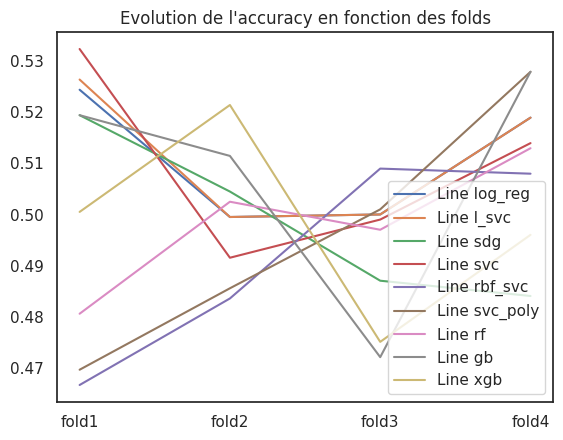

In [ ]:
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:4] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [ ]:
for i in range(9):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]

    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a une accuray de 0.5071665576499971 et un std : 0.013642594803812124
Le modèle N° 1 a une accuray de 0.5079629739747478 et un std : 0.013796856485223205
Le modèle N° 2 a une accuray de 0.49959683653445913 et un std : 0.014372376769720698
Le modèle N° 3 a une accuray de 0.508162573586252 et un std : 0.01577551273924218
Le modèle N° 4 a une accuray de 0.49562744048680896 et un std : 0.019678333334804315
Le modèle N° 5 a une accuray de 0.4980168876731878 et un std : 0.021931640939285013
Le modèle N° 6 a une accuray de 0.4974137281718896 et un std : 0.011848185547741367
Le modèle N° 7 a une accuray de 0.5055715446671026 et un std : 0.021889848830287287
Le modèle N° 8 a une accuray de 0.49501555965193944 et un std : 0.01796532983247956


Le modèle ayant obtenu la meilleure performance selon cette métrique est le SVM avec noyau linéaire, avec une moyenne de 0,51 sur les 5 folds. Cependant, il ressort comme étant le plus instable. Par conséquent, nous allons nous intéresser à l'ajustement des modèles au jeu test après leur optimisation.

### 3) Optimisation des modèles choisis

Afin d'optimiser notre modèle utilise la méthode du *GridsearchCV*.


#### SVM avec un noyau linéaire

In [ ]:
#Obtenir les hyperparamètres du modèle
#On visualise en même temps les valeurs des hyperparamètres par défaut.
SVC(kernel="linear").get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# Tuning
params_svc = [{"kernel": ["linear"], "C" : [0.5, 1, 10, 50,100,1000]}]

c_svc = SVC(random_state=42)

In [ ]:
grid_c_svc = GridSearchCV(c_svc, param_grid=params_svc, cv=5, scoring='accuracy')

In [ ]:
take_grid = grid_c_svc.fit(X_train_resampled_sc, y_train_resampled)

In [ ]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 1, 'kernel': 'linear'}
pour un score de: 0.508162573586252


Le meilleur modèle a pour valeur C=1.

In [ ]:
best_svc = SVC(random_state=42, C=1, kernel='linear')

In [ ]:
best_svc.fit(X_train_resampled_sc, y_train_resampled)

SVC(C=1, kernel='linear', random_state=42)

- Indicateurs de performance

In [ ]:
#Indicateur du modèle
indicateur(best_svc,X_train_resampled_sc, y_train_resampled,"Train")
indicateur(best_svc,X_test_sc, y_test,"Test")

Indicateurs de l'échantillon Train :
Matrice de confusion :
[[1378 1133]
 [1221 1290]]
Qualité du modèle (Accuracy) : 0.53
Taux d'erreur : 0.47
Recall : 0.51
Precision : 0.53
F1 Score  : 0.52
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[551 574]
 [338 290]]
Qualité du modèle (Accuracy) : 0.48
Taux d'erreur : 0.52
Recall : 0.46
Precision : 0.34
F1 Score  : 0.39


- Matrice de confusion

<Figure size 300x200 with 0 Axes>

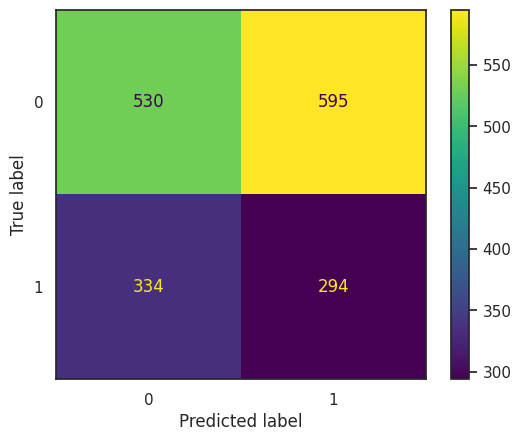

In [ ]:
plt.figure(figsize=(3,2))
# Prédictions
predictions = best_svc.predict(X_test_sc)

# Matrice de confusion
cm = confusion_matrix(y_test, predictions)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Bien qu'un grand nombre d'individus soient bien classés, nous avons également de nombreux individus mal classés.


#### SVC linéaire

In [ ]:
#Obtenir les hyperparamètres du modèle
#On visualise en même temps les valeurs des hyperparamètres par défaut.
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': 'auto',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
# Tuning
params_l_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2'],
    'max_iter': [1000, 2000, 5000]
}

c_l_svc = LinearSVC(random_state=42)

In [ ]:
grid_c_l_svc = GridSearchCV(c_l_svc, param_grid=params_l_svc, cv=5, return_train_score=True)

In [ ]:
take_grid_l_svc = grid_c_l_svc.fit(X_train_resampled_sc, y_train_resampled)

In [ ]:
print("La meilleure combinaison d'estimateur est: " + str(take_grid_l_svc.best_params_)+"\n"
      "pour un score de: " + str(take_grid_l_svc.best_score_))

La meilleur combinaison d'estimateur est: {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
pour un score de: 0.5081619789498723


La meilleure combinaison d'estimateur est: {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2'}
pour un score de: 0.5081619789498723

In [ ]:
best_l_svc = LinearSVC(random_state=42, C=1, class_weight='balanced', loss='squared_hinge', max_iter=1000, penalty='l2')

In [ ]:
best_l_svc.fit(X_train_resampled_sc, y_train_resampled)

LinearSVC(C=1, class_weight='balanced', random_state=42)

- Indicateurs de performance

In [ ]:
#Indicateur du modèle
indicateur(best_l_svc,X_train_resampled_sc, y_train_resampled,"Train")
indicateur(best_l_svc,X_test_sc, y_test,"Test")

Indicateurs de l'échantillon Train :
Matrice de confusion :
[[1346 1165]
 [1189 1322]]
Qualité du modèle (Accuracy) : 0.53
Taux d'erreur : 0.47
Recall : 0.53
Precision : 0.53
F1 Score  : 0.53
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[565 560]
 [331 297]]
Qualité du modèle (Accuracy) : 0.49
Taux d'erreur : 0.51
Recall : 0.47
Precision : 0.35
F1 Score  : 0.4


- Matrice de confusion

<Figure size 300x200 with 0 Axes>

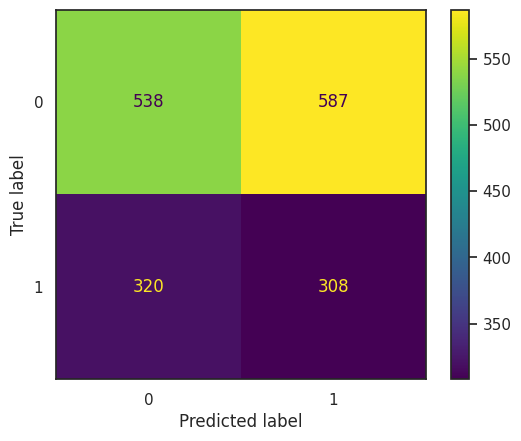

In [ ]:
plt.figure(figsize=(3,2))
# Prédictions
predictions = best_l_svc.predict(X_test_sc)

# Matrice de confusion
cm = confusion_matrix(y_test, predictions)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Régression logistique

In [ ]:
#Obtenir les hyperparamètres du modèle
#On visualise en même temps les valeurs des hyperparamètres par défaut.
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# tuning
params_lgr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200, 300]
}

c_lgr = LogisticRegression(random_state=42)

In [ ]:
grid_c_lgr = GridSearchCV(c_lgr, param_grid=params_lgr, cv=5, return_train_score=True)

In [ ]:
take_grid_lgr = grid_c_lgr.fit(X_train_resampled_sc, y_train_resampled)

In [ ]:
print("La meilleure combinaison d'estimateur est: " + str(take_grid_lgr.best_params_)+"\n"
      "pour un score de: " + str(take_grid_lgr.best_score_))

La meilleure combinaison d'estimateur est: {'C': 0.001, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
pour un score de: 0.5091562109769875


La meilleure combinaison d'estimateur est: {'C': 0.001, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
pour un score de: 0.5091562109769875



In [ ]:
best_lgr = LogisticRegression(random_state=42, C=0.001, class_weight=None, max_iter=100, penalty='l2', solver='liblinear')

In [ ]:
best_lgr.fit(X_train_resampled_sc, y_train_resampled)

LogisticRegression(C=0.001, random_state=42, solver='liblinear')

In [ ]:
#Indicateur du modèle
indicateur(best_lgr,X_train_resampled_sc, y_train_resampled,"Train")
indicateur(best_lgr,X_test_sc, y_test,"Test")

Indicateurs de l'échantillon Train :
Matrice de confusion :
[[1457 1054]
 [1308 1203]]
Qualité du modèle (Accuracy) : 0.53
Taux d'erreur : 0.47
Recall : 0.48
Precision : 0.53
F1 Score  : 0.5
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[619 506]
 [348 280]]
Qualité du modèle (Accuracy) : 0.51
Taux d'erreur : 0.49
Recall : 0.45
Precision : 0.36
F1 Score  : 0.4


#### SGD Classifier

In [ ]:
#Obtenir les hyperparamètres du modèle
#On visualise en même temps les valeurs des hyperparamètres par défaut.
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# tuning
params_sdg = {
    'loss': ['hinge', 'log'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-3, 1e-4],
    'max_iter': [1000, 2000, 3000],
    'learning_rate': ['constant', 'optimal']
}


c_sdg = SGDClassifier(random_state=42)

In [ ]:
grid_c_sdg = GridSearchCV(c_sdg, param_grid=params_sdg, cv=5, return_train_score=True)

In [ ]:
take_grid_sdg = grid_c_sdg.fit(X_train_resampled_sc, y_train_resampled)

In [ ]:
print("La meilleure combinaison d'estimateur est: " + str(take_grid_sdg.best_params_)+"\n"
      "pour un score de: " + str(take_grid_sdg.best_score_))

La meilleure combinaison d'estimateur est: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
pour un score de: 0.5067691423361282


In [ ]:
best_sdg = SGDClassifier(random_state=42, alpha=1e-05, learning_rate='optimal', loss='hinge', penalty='l2')

In [ ]:
best_sdg.fit(X_train_resampled_sc, y_train_resampled)

SGDClassifier(alpha=1e-05, random_state=42)

In [ ]:
#Indicateur du modèle
indicateur(best_sdg,X_train_resampled_sc, y_train_resampled,"Train")
indicateur(best_sdg,X_test_sc, y_test,"Test")

Indicateurs de l'échantillon Train :
Matrice de confusion :
[[1857  654]
 [1825  686]]
Qualité du modèle (Accuracy) : 0.51
Taux d'erreur : 0.49
Recall : 0.27
Precision : 0.51
F1 Score  : 0.36
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[815 310]
 [464 164]]
Qualité du modèle (Accuracy) : 0.56
Taux d'erreur : 0.44
Recall : 0.26
Precision : 0.35
F1 Score  : 0.3


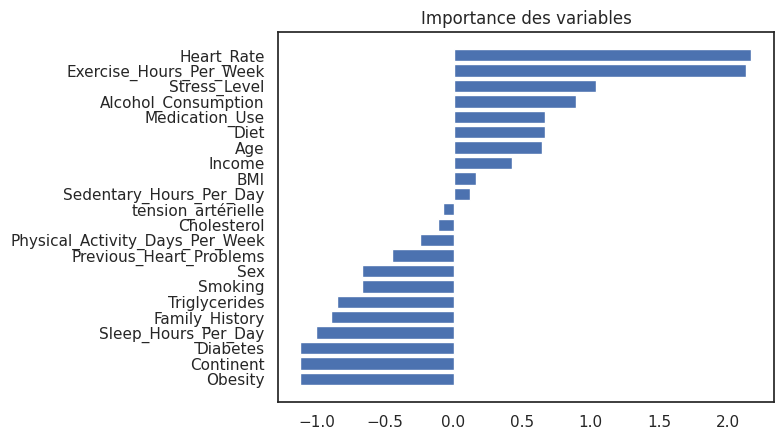

In [ ]:
coef_svm = best_sdg.coef_[0]

svm_f_importances(coef_svm , X_train_resampled_sc.columns)

# IV. Interprétation du meilleur modèle


##  A. Interprétation globale


### 1) Partial Dependence Plots - PDP

In [ ]:
features_quali = ['Sex', 'Diabetes', 'Family_History', 'Smoking', 'Obesity',
                  'Alcohol_Consumption', 'Diet', 'Previous_Heart_Problems',
                  'Medication_Use', 'Continent']

features_quanti = ['Age', 'Cholesterol',
                   'tension_artérielle', 'Heart_Rate',
                   'Exercise_Hours_Per_Week', 'Stress_Level',
                   'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                   'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day']

#### Pour les variables quantitatives :

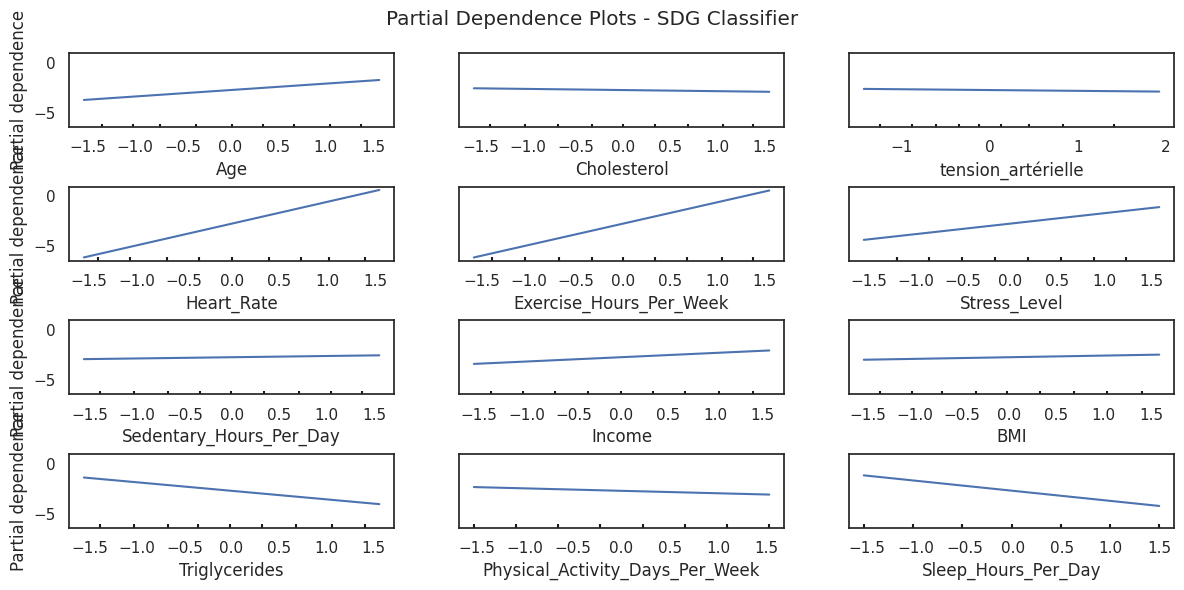

In [ ]:
_, ax1 = plt.subplots(figsize = (12,6))

PartialDependenceDisplay.from_estimator(best_sdg,
                                         X_train_resampled_sc,
                                         features_quanti,
                                         kind="average",
                                         grid_resolution=50,
                                         ax = ax1
                                         )

plt.suptitle("Partial Dependence Plots - SDG Classifier")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

plt.show()

La Partial Dependence Display nous permet d’affirmer que les variables âge, cholestérol, tension artérielle, heures d'exercice par semaine, IMC, revenu et triglycérides ont un lien positif avec le risque de crise cardiaque, tandis que les variables fréquence cardiaque, niveau de stress, heures de sédentarité par jour, jours d'activité physique par semaine et heures de sommeil par jour ont un lien négatif avec ce risque.

#### Pour les variables qualitatives :

In [ ]:
X_train_resampled_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5022 entries, 0 to 5021
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sex                              5022 non-null   int64  
 1   Diabetes                         5022 non-null   int64  
 2   Family_History                   5022 non-null   int64  
 3   Smoking                          5022 non-null   int64  
 4   Obesity                          5022 non-null   int64  
 5   Alcohol_Consumption              5022 non-null   int64  
 6   Diet                             5022 non-null   int64  
 7   Previous_Heart_Problems          5022 non-null   int64  
 8   Medication_Use                   5022 non-null   int64  
 9   Continent                        5022 non-null   int64  
 10  Age                              5022 non-null   float64
 11  Cholesterol                      5022 non-null   float64
 12  tension_artérielle  

In [ ]:
#One hot encoding des catégories
sex_cat = pd.get_dummies(X_train_resampled_sc.Sex, prefix="sex")
diabetes_cat = pd.get_dummies(X_train_resampled_sc.Diabetes, prefix="diabetes")
family_cat = pd.get_dummies(X_train_resampled_sc.Family_History, prefix="family")
smoking_cat = pd.get_dummies(X_train_resampled_sc.Smoking, prefix="smoking")
obesity_cat = pd.get_dummies(X_train_resampled_sc.Obesity, prefix="obesity")
alcohol_cat = pd.get_dummies(X_train_resampled_sc.Alcohol_Consumption, prefix="alcohol")
diet_cat = pd.get_dummies(X_train_resampled_sc.Diet, prefix="diet")
problems_cat = pd.get_dummies(X_train_resampled_sc.Previous_Heart_Problems, prefix="problems")
medication_cat = pd.get_dummies(X_train_resampled_sc.Medication_Use, prefix="medication")
continent_cat = pd.get_dummies(X_train_resampled_sc.Continent, prefix="continent")



In [ ]:
X_train_resampled_sc_one = pd.concat([X_train_resampled_sc, sex_cat,diabetes_cat,family_cat,smoking_cat,obesity_cat,alcohol_cat,diet_cat,problems_cat, medication_cat, continent_cat], axis=1)\
            .drop(['Sex', 'Diabetes', 'Family_History', 'Smoking', 'Obesity',
                  'Alcohol_Consumption', 'Diet', 'Previous_Heart_Problems',
                  'Medication_Use', 'Continent'],axis=1)

In [ ]:
X_train_resampled_sc_one.columns

Index(['Age', 'Cholesterol', 'tension_artérielle', 'Heart_Rate',
       'Exercise_Hours_Per_Week', 'Stress_Level', 'Sedentary_Hours_Per_Day',
       'Income', 'BMI', 'Triglycerides', 'Physical_Activity_Days_Per_Week',
       'Sleep_Hours_Per_Day', 'sex_0', 'sex_1', 'diabetes_0', 'diabetes_1',
       'family_0', 'family_1', 'smoking_0', 'smoking_1', 'obesity_0',
       'obesity_1', 'alcohol_0', 'alcohol_1', 'diet_0', 'diet_1', 'diet_2',
       'problems_0', 'problems_1', 'medication_0', 'medication_1',
       'continent_0', 'continent_1', 'continent_2', 'continent_3',
       'continent_4', 'continent_5'],
      dtype='object')

In [ ]:
best_sdg.fit(X_train_resampled_sc_one, y_train_resampled)

SGDClassifier(alpha=1e-05, random_state=42)

ValueError: cannot reshape array of size 1 into shape (2)

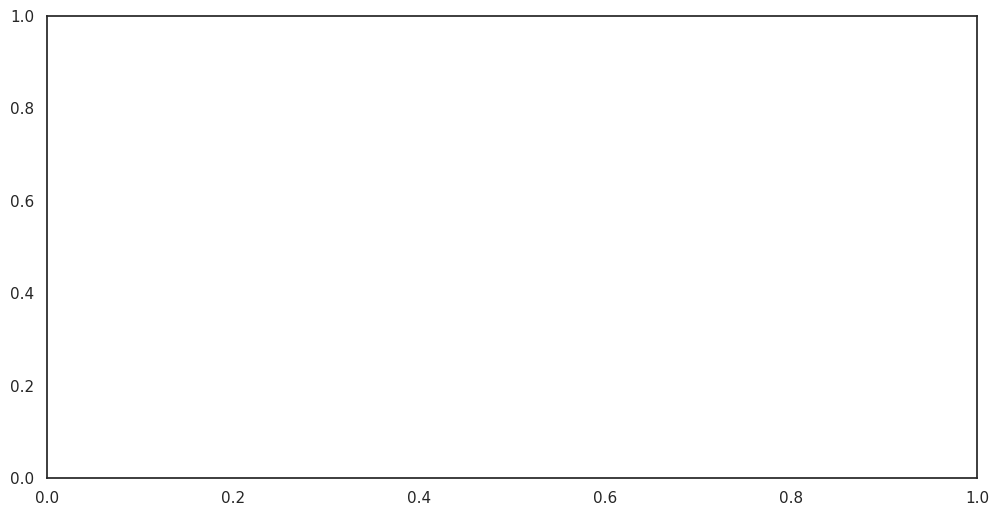

In [ ]:
features_quali = ['sex_0', 'sex_1', 'diabetes_0', 'diabetes_1',
       'family_0', 'family_1', 'smoking_0', 'smoking_1', 'obesity_0',
       'obesity_1', 'alcohol_0', 'alcohol_1', 'diet_0', 'diet_1', 'diet_2',
       'problems_0', 'problems_1', 'medication_0', 'medication_1',
       'continent_0', 'continent_1', 'continent_2', 'continent_3',
       'continent_4', 'continent_5']

_, ax1 = plt.subplots(figsize=(12, 6))

PartialDependenceDisplay.from_estimator(
    best_sdg,
    X_train_resampled_sc_one,
    features_quali,
    categorical_features=['sex_0', 'sex_1', 'diabetes_0', 'diabetes_1',
       'family_0', 'family_1', 'smoking_0', 'smoking_1', 'obesity_0',
       'obesity_1', 'alcohol_0', 'alcohol_1', 'diet_0', 'diet_1', 'diet_2',
       'problems_0', 'problems_1', 'medication_0', 'medication_1',
       'continent_0', 'continent_1', 'continent_2', 'continent_3',
       'continent_4', 'continent_5'],
    kind="average",
    grid_resolution=50,
    ax=ax1,
    n_cols=4
)

plt.suptitle("Partial Dependence Plots - SGD Classifier (Quali)")
plt.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()

### 2) Permutation features importance

In [ ]:
best_sdg.fit(X_train_resampled_sc, y_train_resampled)

SGDClassifier(alpha=1e-05, random_state=42)

In [ ]:
result = permutation_importance(best_sdg, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0
                           )

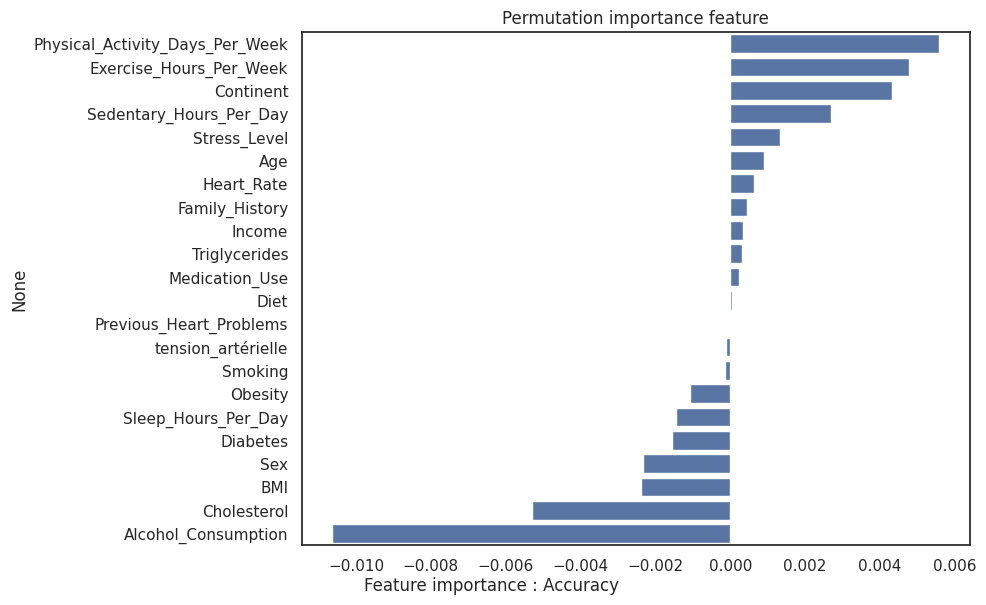

In [ ]:
perm_sorted_idx = result.importances_mean.argsort()

# Trier les indices des features par importance
perm_sorted_idx = result.importances_mean.argsort()[::-1]

# Créer la figure et l'axe
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

X_test_sc_data = pd.DataFrame(X_test_sc, columns=X_test.columns)

# Utiliser sns.barplot pour afficher les importances des features triées
sns.barplot(
    x=result.importances_mean[perm_sorted_idx],  # Moyenne des importances
    y=X_test_sc_data.columns[perm_sorted_idx],
    orient='h',  # Affichage horizontal
    ax=ax1
)

plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Accuracy", ha='center')

fig.tight_layout()
plt.show()



## B. Interprétation locale de notre meilleur modèle

### 1) ICE

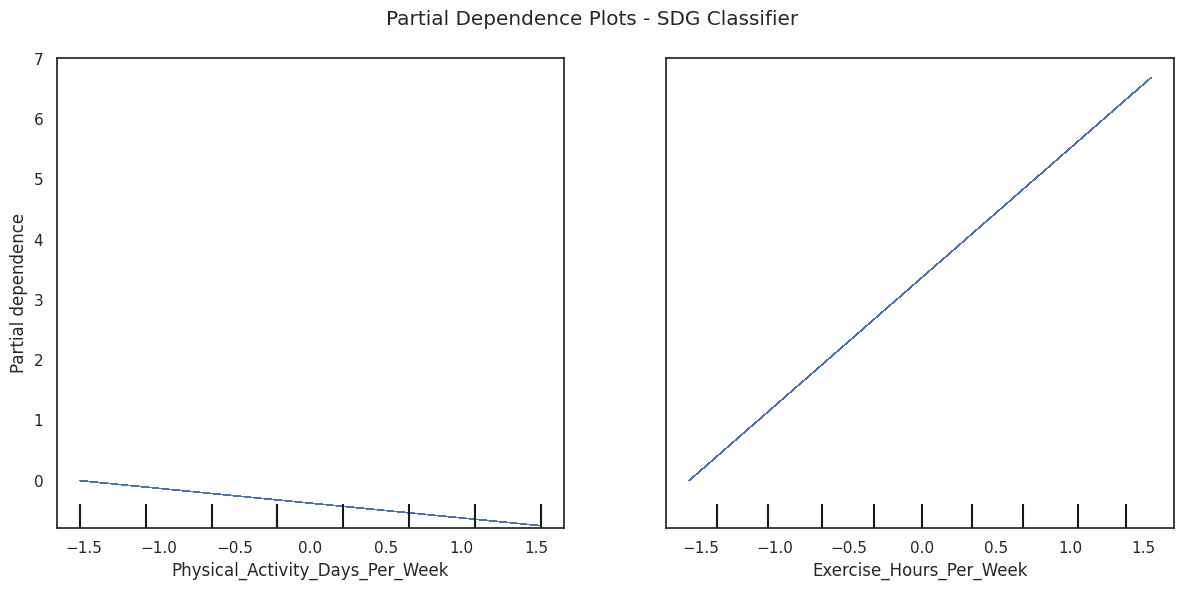

In [ ]:
# ICE pour plusieurs caractéristiques
features = ["Physical_Activity_Days_Per_Week","Exercise_Hours_Per_Week"] # Index des caractéristiques les plus importantes

_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_sdg,
                                         X_train_resampled_sc,
                                         features=features,
                                         kind="individual",
                                         ax = ax1,
                                         grid_resolution=10,
                                         n_cols=3,
                                         subsample=0.05,
                                         centered=True
                                         )
plt.suptitle("Partial Dependence Plots - SDG Classifier")
plt.tight_layout()
plt.show()

### 2) LIME

In [ ]:
features_names = ['Sex', 'Diabetes', 'Family_History', 'Smoking', 'Obesity',
       'Alcohol_Consumption', 'Diet', 'Previous_Heart_Problems',
       'Medication_Use', 'Continent', 'Age', 'Cholesterol',
       'tension_artérielle', 'Heart_Rate', 'Exercise_Hours_Per_Week',
       'Stress_Level', 'Sedentary_Hours_Per_Day', 'Income', 'BMI',
       'Triglycerides', 'Physical_Activity_Days_Per_Week',
       'Sleep_Hours_Per_Day']

In [ ]:
#! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9503a4c0198fd7ef2648aca40ac97325fe76fdfdc2f9d2198af3675d5628bc43
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime.lime_tabular

# 1. Modèle avec loss='log_loss' pour avoir predict_proba
best_sdg = SGDClassifier(random_state=42, alpha=1e-05, learning_rate='optimal', loss='log_loss', penalty='l2')
best_sdg.fit(X_train_resampled_sc, y_train_resampled)

# 2. Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_resampled_sc.to_numpy(),
    feature_names=features_names,
    class_names=['No Heart Attack', 'Heart Attack'],
    mode="classification",
    verbose=True,
)

# Choisir un exemple à expliquer
i = 118
exp = explainer.explain_instance( X_train_resampled_sc.loc[i].to_numpy(), best_sdg.predict_proba, num_features=5)


Intercept 0.26559935898463616
Prediction_local [0.39092027]
Right: 0.1204028193987325


In [ ]:
# Afficher les explications
exp.show_in_notebook()

# V. Supplément : Essai avec SMOTE

Cette méthode est une technique de suréchantillonnage utilisée pour équilibrer les ensembles de données déséquilibrés. L'objectif de SMOTE est de générer des exemples synthétiques pour la classe minoritaire afin d'augmenter sa taille et d'équilibrer les classes dans le jeu de données. <br>

Cela a été en vain car les résultats ne se sont pas améliorés.



In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_resampled_sm, y_train_resampled_sm = sm.fit_resample(X_train, y_train)

In [ ]:
print(X_train_resampled_sm.shape)

(8998, 22)


In [ ]:
y_train_resampled_sm.value_counts()

,count
Heart_Attack_Risk,
0,4499
1,4499


In [ ]:
columns_to_scale = ['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day']


scaler = StandardScaler()
scaler.fit_transform(X_train_resampled_sm[columns_to_scale])

array([[ 1.47995838, -0.55595602, -0.30305389, ...,  0.5870388 ,
        -0.18061614, -0.48276953],
       [ 1.67529618, -0.65856862,  0.43769199, ...,  1.06913025,
        -0.63508594, -1.52373772],
       [ 1.77296507, -0.46617   ,  2.11034397, ..., -0.73986055,
         0.27385366, -1.00325363],
       ...,
       [-0.42458508, -1.36403021, -0.44656937, ..., -0.81791345,
        -1.54402555, -1.00325363],
       [-1.49894293,  0.54712938,  0.04116118, ...,  0.20595698,
        -0.18061614,  0.55819866],
       [ 0.94277946, -0.08137277, -0.05951009, ...,  1.66141405,
        -1.54402555, -1.52373772]])

In [ ]:
X_train_resampled_sm[columns_to_scale]

,Age,Cholesterol,tension_artérielle,Heart_Rate,Exercise_Hours_Per_Week,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day
0,84,217,1.510000,75,17.107142,10,1.737428,153618,35.185856,544,3,6
1,88,209,1.820000,104,2.851698,1,11.876890,124693,30.991599,649,2,4
2,90,224,2.520000,98,3.560949,10,9.618701,154900,22.851796,255,4,5
3,27,376,2.010000,65,19.035090,4,1.968503,151338,37.513424,796,1,4
4,55,270,1.800000,94,0.968271,6,7.252388,81127,23.269040,450,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8993,52,290,1.904586,98,10.965811,3,0.707330,79850,33.956419,336,0,8
8994,51,346,1.806200,89,15.208184,8,1.468057,38475,21.056350,781,3,5
8995,45,154,1.449939,51,3.506355,4,10.765660,298731,27.238106,238,0,5
8996,23,303,1.654053,56,8.133593,6,4.492208,46939,21.300309,461,3,8


In [ ]:
X_train_resampled_sm_sc = scaler.transform(X_train_resampled_sm[columns_to_scale])
X_test_sc = scaler.transform(X_test[columns_to_scale])

In [ ]:
# Convertir les résultats de la transformation en DataFrame et conserver les noms de colonnes
X_train_resampled_sm_sc = pd.DataFrame(X_train_resampled_sm_sc, columns=['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

X_test_sc= pd.DataFrame(X_test_sc, columns=['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

In [ ]:
# Réinitialiser les indices après transformation
X_train_resampled_sm_sc.reset_index(drop=True, inplace=True)
X_test_sc.reset_index(drop=True, inplace=True)

In [ ]:
X_train_resampled_sm_sc

,Age,Cholesterol,tension_artérielle,Heart_Rate,Exercise_Hours_Per_Week,Stress_Level,Sedentary_Hours_Per_Day,Income,BMI,Triglycerides,Physical_Activity_Days_Per_Week,Sleep_Hours_Per_Day
0,1.479958,-0.555956,-0.303054,0.003051,1.269787,1.688797,-1.273314,-0.068328,1.031679,0.587039,-0.180616,-0.482770
1,1.675296,-0.658569,0.437692,1.463955,-1.288558,-1.573659,1.769277,-0.425513,0.340338,1.069130,-0.635086,-1.523738
2,1.772965,-0.466170,2.110344,1.161699,-1.161273,1.688797,1.091653,-0.052497,-1.001348,-0.739861,0.273854,-1.003254
3,-1.303605,1.483469,0.891698,-0.500709,1.615785,-0.486174,-1.203975,-0.096483,1.415333,1.744058,-1.089556,-1.523738
4,0.063759,0.123852,0.389902,0.960195,-1.626566,0.238816,0.381583,-0.963493,-0.932574,0.155452,-0.635086,-1.523738
...,...,...,...,...,...,...,...,...,...,...,...,...
8993,-0.082744,0.380384,0.639810,1.161699,0.167636,-0.848669,-1.582420,-0.979262,0.829031,-0.367961,-1.544026,0.558199
8994,-0.131578,1.098672,0.404718,0.708315,0.928991,0.963806,-1.354146,-1.490187,-1.297292,1.675188,-0.180616,-1.003254
8995,-0.424585,-1.364030,-0.446569,-1.205973,-1.171070,-0.486174,1.435826,1.723620,-0.278351,-0.817913,-1.544026,-1.003254
8996,-1.498943,0.547129,0.041161,-0.954093,-0.340646,0.238816,-0.446676,-1.385668,-1.257080,0.205957,-0.180616,0.558199


In [ ]:
var_quali_train_sm = X_train_resampled_sm.drop(columns = ['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

var_quali_test = X_test.drop(columns = ['Age', 'Cholesterol',
                    'tension_artérielle', 'Heart_Rate',
                    'Exercise_Hours_Per_Week', 'Stress_Level',
                    'Sedentary_Hours_Per_Day', 'Income', 'BMI',
                    'Triglycerides', 'Physical_Activity_Days_Per_Week', 'Sleep_Hours_Per_Day'])

In [ ]:
print(var_quali_train_sm)

      Sex  Diabetes  Family_History  Smoking  Obesity  Alcohol_Consumption  \
0       1         1               1        1        1                    1   
1       1         1               0        1        0                    1   
2       1         1               0        1        0                    1   
3       1         0               0        1        0                    1   
4       1         0               1        1        1                    1   
...   ...       ...             ...      ...      ...                  ...   
8993    1         1               1        1        0                    1   
8994    1         0               0        1        1                    0   
8995    0         0               0        0        0                    1   
8996    1         0               1        1        1                    0   
8997    0         1               0        1        1                    1   

      Diet  Previous_Heart_Problems  Medication_Use  Continent 

In [ ]:
# Concatenation des DataFrames après réinitialisation des indices
X_train_resampled_sm_sc = pd.concat([var_quali_train_sm.reset_index(drop=True), X_train_resampled_sm_sc], axis=1)
X_test_sc = pd.concat([var_quali_test.reset_index(drop=True), X_test_sc], axis=1)

In [ ]:
print(X_train_resampled_sm_sc)

      Sex  Diabetes  Family_History  Smoking  Obesity  Alcohol_Consumption  \
0       1         1               1        1        1                    1   
1       1         1               0        1        0                    1   
2       1         1               0        1        0                    1   
3       1         0               0        1        0                    1   
4       1         0               1        1        1                    1   
...   ...       ...             ...      ...      ...                  ...   
8993    1         1               1        1        0                    1   
8994    1         0               0        1        1                    0   
8995    0         0               0        0        0                    1   
8996    1         0               1        1        1                    0   
8997    0         1               0        1        1                    1   

      Diet  Previous_Heart_Problems  Medication_Use  Continent 

In [ ]:
#Regression logistique
log_reg_sm = LogisticRegression(random_state=42)
log_reg_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#LinearSVC
l_svc_sm= LinearSVC(random_state=42, max_iter=2000)
l_svc_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#SGDClassifier
sdg_sm = SGDClassifier(loss='hinge' ,random_state=42)
sdg_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#SVM avec kernel linéaire
svc_sm = SVC(kernel="linear", random_state=42)
svc_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#SVM avec noyau RBF
rbf_svc_sm = SVC(kernel='rbf', random_state=42)
rbf_svc_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#SGD avec noyau poly
svc_poly_sm = SVC(kernel='poly',random_state=0)
svc_poly_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#Random Forest
rf_sm = RandomForestClassifier(random_state=42)
rf_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#Gradient Boosting
gb_sm = GradientBoostingClassifier(random_state=42)
gb_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

#XGBoost
xgb_sm = XGBClassifier(random_state=42)
xgb_sm.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Dictionnaire des modèles
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Linear SVC": LinearSVC(random_state=42, max_iter=2000),
    "SGD Classifier": SGDClassifier(loss='hinge', random_state=42),
    "SVM (Linear)": SVC(kernel="linear", random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "SVM (Poly)": SVC(kernel='poly', random_state=0),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Entraînement de tous les modèles et application des indicateurs
for name, model in models.items():
    print(f"\nEntraînement et évaluation du modèle: {name}")
    # Entraînement du modèle
    model.fit(X_train_resampled_sm_sc, y_train_resampled_sm)

    # Application de la fonction indicateur sur l'entraînement et le test
    indicateur(model, X_train_resampled_sm_sc, y_train_resampled_sm, "Train")
    indicateur(model, X_test_sc, y_test, "Test")



Entraînement et évaluation du modèle: Logistic Regression
Indicateurs de l'échantillon Train :
Matrice de confusion :
[[2815 1684]
 [1763 2736]]
Qualité du modèle (Accuracy) : 0.62
Taux d'erreur : 0.38
Recall : 0.61
Precision : 0.62
F1 Score  : 0.61
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[680 445]
 [383 245]]
Qualité du modèle (Accuracy) : 0.53
Taux d'erreur : 0.47
Recall : 0.39
Precision : 0.36
F1 Score  : 0.37

Entraînement et évaluation du modèle: Linear SVC
Indicateurs de l'échantillon Train :
Matrice de confusion :
[[2821 1678]
 [1768 2731]]
Qualité du modèle (Accuracy) : 0.62
Taux d'erreur : 0.38
Recall : 0.61
Precision : 0.62
F1 Score  : 0.61
Indicateurs de l'échantillon Test :
Matrice de confusion :
[[679 446]
 [384 244]]
Qualité du modèle (Accuracy) : 0.53
Taux d'erreur : 0.47
Recall : 0.39
Precision : 0.35
F1 Score  : 0.37

Entraînement et évaluation du modèle: SGD Classifier
Indicateurs de l'échantillon Train :
Matrice de confusion :
[[2801 1698]
 [1930

Il y a beaucoup trop d'overfitting. Nous nous arrêtons là.